In [1884]:
# Стандартный стэк
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1885]:
to_scale = set()
to_log = set()
to_ohe = set()
to_minmax = set()
to_drop = set()
to_encode = set()

### Собираем файлы по разным кол-вам комнат ###

In [1902]:
files = [1, 2, 3, 4, 5,  9]

df = pd.DataFrame(pd.read_csv(f'../data/raw/{files[0]}_rooms_full.csv'))
for i in files[1:]:
    data = pd.read_csv(f'../data/raw/{i}_rooms_full.csv')
    df_temp = pd.DataFrame(data)
    df = pd.concat([df, df_temp], axis = 0)
df = df.reset_index(drop=True)

In [1903]:
df = df[df['processed']=='y']
df = df.drop(['title','subtitle', 'link', 'processed'], axis=1)

In [1904]:
df.shape[0]

19423

In [1905]:
df.isnull().sum()

rooms                      0
subway                    17
dist_to_subway            18
city                      81
admin_okrug               81
district                  81
street                   203
home_number             2410
price                      0
year_of_construction       0
total_meters               0
living_meters              0
kitchen_meters             0
floor                      0
floors_count               0
flat_type                  0
house_type                 0
wc                         0
ceiling                    0
class                      0
dtype: int64

Нулевых значений почти нет, тк мы заполняли пропуски -1 при работе парсера. Проверим долю -1

In [1906]:
df = df.replace(-1.0, '-1').replace('-1', None)

In [1907]:
df.isna().mean()*100

rooms                    0.000000
subway                   0.087525
dist_to_subway           0.092674
city                     0.417031
admin_okrug              0.417031
district                 0.417031
street                   1.045153
home_number             12.407970
price                    0.000000
year_of_construction     3.624569
total_meters             0.000000
living_meters           24.501879
kitchen_meters          23.307419
floor                    0.000000
floors_count             0.000000
flat_type                0.000000
house_type              11.362817
wc                      21.294342
ceiling                 28.749421
class                   65.865211
dtype: float64

Как видим, больше всего пропусков в классе жилья (Бизнес / Комфорт / Премиум), кроме того часто не заполнена информация о высоте потолков и наличии санузлов.

Пройдем по колонкам и подготовим их к анализу

In [1908]:
df.district.unique()

array(['р-н Покровское-Стрешнево', 'р-н Хорошево-Мневники', 'р-н Щукино',
       'р-н Митино', 'р-н Строгино', 'м. Прокшино', 'м. Филатов Луг',
       'м. Румянцево', 'м. Коммунарка', 'м. Саларьево',
       'м. Улица Горчакова', 'м. Рассказовка', 'м. Ольховая',
       'м. Бунинская аллея', 'Филимонковское поселение',
       'м. Улица Скобелевская', 'р-н Тверской', 'р-н Хамовники',
       'р-н Пресненский', 'р-н Якиманка', 'р-н Замоскворечье',
       'р-н Арбат', 'р-н Таганский', 'р-н Басманный',
       'р-н Красносельский', 'р-н Савеловский', 'р-н Аэропорт',
       'р-н Беговой', 'р-н Хорошевский', 'р-н Западное Дегунино',
       'р-н Бескудниковский', 'р-н Тимирязевский', 'р-н Дмитровский',
       'р-н Головинский', 'р-н Сокол', 'р-н Коптево', 'р-н Ховрино',
       'р-н Молжаниновский', 'р-н Войковский', 'р-н Свиблово',
       'р-н Алексеевский', 'р-н Марьина роща', 'р-н Северное Медведково',
       'р-н Ростокино', 'р-н Останкинский', 'р-н Бибирево',
       'р-н Ярославский', 'р-н Ма

### Price - наша целевая переменная ###

In [1909]:
# Убираем лишние символы и знаки рубля, приводим к нужному формату
df.price = df.price.apply(lambda x: x.replace(' ', '')).str.extract('(\d+)').apply(int, axis=1)
df["price"] = df.price.astype(float)

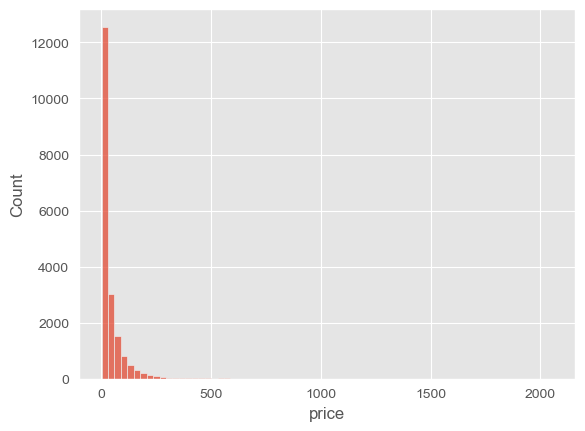

In [1910]:
sns.set_palette("tab10")
sns.set_style('darkgrid')
plt.style.use('ggplot')

sns.histplot(df.price/10**6, bins = 70);

In [1911]:
df.price.max() # Самая дорогая квартира стоит 2 млрд. Надо на нее посмотреть!

2054630000.0

In [1912]:
df[df.price == df.price.max()]

rooms         subway  dist_to_subway    city admin_okrug      district  \
15192      5  Третьяковская  5 минут пешком  Москва         ЦАО  р-н Якиманка   

                street home_number         price year_of_construction  \
15192  Лаврушинский ЖК         NaN  2.054630e+09                 2024   

       total_meters living_meters kitchen_meters  floor  floors_count  \
15192         459.0         135.0           30.0      7             8   

         flat_type  house_type            wc ceiling    class  
15192  Новостройка  Монолитный  4 раздельных  3,35 м  Премиум

Все логично... Посмотрим, какое кол-во квартир у нас находится в хвосте за 150млн рублей

In [1913]:
df[df.price//10**6 > 150]

rooms                    subway         dist_to_subway    city  \
76         1                  Киевская        13 минут пешком  Москва   
661        1  Москва (Киевский вокзал)  7 минут на транспорте  Москва   
919        1             Третьяковская        3 минуты пешком  Москва   
925        1                  Киевская        13 минут пешком  Москва   
1499       1             Третьяковская         5 минут пешком  Москва   
...      ...                       ...                    ...     ...   
18607      5                   Минская        10 минут пешком  Москва   
18613      5                   Минская  8 минут на транспорте  Москва   
18822      9                 Технопарк         5 минут пешком  Москва   
19681      9                 Технопарк         5 минут пешком  Москва   
21211      9               Выставочная         6 минут пешком  Москва   

      admin_okrug                 district                   street  \
76            ЦАО            р-н Хамовники  переулок 1-й Тружеников   
661           ЦАО            р-н Хамовники                      1С1   
919           ЦАО        р-н Замоскворечье        Русские Сезоны ЖК   
925           ЦАО            р-н Хамовники  переулок 1-й Тружеников   
1499          ЦАО             р-н Якиманка          Лаврушинский ЖК   
...           ...                      ...                      ...   
18607         ЗАО              р-н Раменки     Мосфильмовская улица   
18613         ЗАО  р-н Очаково-Матвеевское     Староволынская улица   
18822         ЮАО    р-н Нагатинский затон           Дрим Тауэрс ЖК   
19681         ЮАО    р-н Нагатинский затон           Дрим Тауэрс ЖК   
21211         ЦАО          р-н Пресненский   набережная Пресненская   

      home_number        price year_of_construction  total_meters  \
76             12  176690745.0                 2025         104.0   
661           NaN  208530000.0                 2026          86.0   
919            к4  253462000.0                 2024         115.0   
925            12  162328148.0                 2025         100.0   
1499          NaN  152040000.0                 2024          65.0   
...           ...          ...                  ...           ...   
18607        70к6  285000000.0                 None         625.0   
18613        15к3  209999000.0                 2006         330.0   
18822         NaN  197591993.0                 2023         228.0   
19681         NaN  200029744.0                 2023         232.0   
21211         8с1  180000000.0                 2010         222.0   

      living_meters kitchen_meters  floor  floors_count             flat_type  \
76             None           None      5            14           Новостройка   
661            17.0           37.0      3             6           Новостройка   
919            91.0            8.0      2             4           Новостройка   
925            None           None      2            14           Новостройка   
1499           15.0           26.0      3             8           Новостройка   
...             ...            ...    ...           ...                   ...   
18607         160.0           24.0     16            17              Вторичка   
18613         220.0           30.0      1             6              Вторичка   
18822          None           None     23            24           Новостройка   
19681          None           None     23            24           Новостройка   
21211          None           20.0     41            76  Вторичка Апартаменты   

                house_type             wc ceiling    class  
76     Монолитно-кирпичный           None  3,55 м  Премиум  
661    Монолитно-кирпичный  2 совмещенных  3,35 м  Премиум  
919    Монолитно-кирпичный           None    None     None  
925    Монолитно-кирпичный           None  3,55 м  Премиум  
1499            Монолитный  2 совмещенных  3,35 м  Премиум  
...                    ...            ...     ...      ...  
18607                 None  4 совмещенных   3,1 

Интересно, что у таких многих таких квартир не проставлен класс Премиум. Возможно стоит сделать такую обработку позже.

Из-за наличия хвоста с выбросами есть желание прологарифмировать цены.

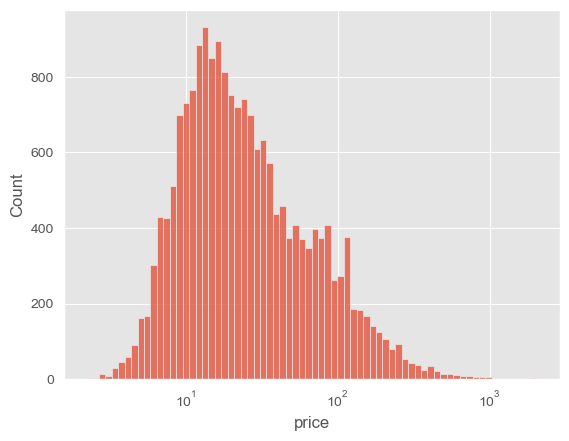

In [1914]:
sns.histplot(df.price/10**6, bins = 70, log_scale=True);

In [1915]:
to_log.add('price') # добавим в список на логарифмирование

### Subway - ближайшее метро ###

In [1916]:
df.subway.value_counts()

Филатов Луг        406
Шелепиха           337
Прокшино           332
Бунинская аллея    326
Павелецкая         304
                  ... 
Чертаново            1
НАТИ                 1
Карачарово           1
Мамонтовская         1
Одинцово             1
Name: subway, Length: 330, dtype: int64

Видно, что наибольшее количество квартир в районах новой крупной застройки: Филатов Луг, Шелепиха, Рассказовка и тд - все районы застройки масштабными ЖК

In [1917]:
df[df.subway.isna()]

rooms subway dist_to_subway    city           admin_okrug  \
1472       1    NaN            NaN  Москва  НАО (Новомосковский)   
2294       1    NaN            NaN  Москва  НАО (Новомосковский)   
2936       1    NaN            NaN  Москва                  СВАО   
5516       2    NaN            NaN  Москва                  ЮВАО   
7450       2    NaN            NaN  Москва                   ВАО   
8585       2    NaN            NaN  Москва                   ВАО   
11500      4    NaN            NaN  Москва                   ВАО   
12771      4    NaN            NaN  Москва  НАО (Новомосковский)   
12897      4    NaN            NaN  Москва                   ВАО   
13457      4    NaN            NaN  Москва                   ВАО   
13676      4    NaN            NaN  Москва                   САО   
13734      4    NaN            NaN  Москва                   ВАО   
14011      4    NaN            NaN  Москва                   ВАО   
14291      4    NaN            NaN  Москва                   ВАО   
14571      4    NaN            NaN  Москва                   ВАО   
18943      9    NaN            NaN  Москва  НАО (Новомосковский)   
19147      9    NaN            NaN  Москва                  ЮЗАО   

                    district street home_number       price  \
1472   Десеновское поселение    1к6         NaN   7200000.0   
2294   Десеновское поселение    1к6         NaN   6400000.0   
2936        р-н Алексеевский      4         NaN  10500000.0   
5516        р-н Текстильщики      4         NaN   9500000.0   
7450           р-н Гольяново    1К1         NaN  11100000.0   
8585           р-н Гольяново    1К1         NaN  11100000.0   
11500     р-н Соколиная гора      6         NaN  16680000.0   
12771  Десеновское поселение    1к4         NaN  15900000.0   
12897     р-н Соколиная гора      6         NaN  16680000.0   
13457     р-н Соколиная гора      6         NaN  16680000.0   
13676            р-н Ховрино   48К1         NaN  15600000.0   
13734     р-н Соколиная гора      6         NaN  16680000.0   
14011     р-н Соколиная гора      6         NaN  16680000.0   
14291     р-н Соколиная гора      6         NaN  16680000.0   
14571     р-н Соколиная гора      6         NaN  16680000.0   
18943  Десеновское поселение    1к1         NaN   7100000.0   
19147       р-н Южное Бутово     15         NaN   4250000.0   

      year_of_construction  total_meters living_meters kitchen_meters  floor  \
1472                  2022          31.0          15.0            8.0     15   
2294                  2022          32.0          None           None      8   
2936                  1965          34.0          20.0            4.0      2   
5516                  1964          37.0          25.0           None      2   
7450                  1968          46.0          28.0            6.0      5   
8585                  1968          44.0          29.0            5.0      2   
11500                 1957          96.0          73.0            8.0      1   
12771                 2021          76.0          36.0           20.0      2   
12897                 1957          96.0          73.0            8.0      1   
13457                 1957          96.0          73.0            8.0      1   
13676                 1967          62.0          None            6.0      6   
13734                 1957          96.0          73.0            8.0      1   
14011                 1957          96.0          73.0            8.0      1   
14291                 1957          96.0          73.0            8.0      1   
14571                 1957          96.0          73.0            8.0      1   
18943                 2021          30.0          15.0            6.0      4   
19147                 1996          18.0          None           None      1   

       floors_count flat_type  house_type             wc ceiling class  
1472             17  Вторичка        None  1 совмещенный   2,7 м  None  
2294             17  Вторичка        None           None    

В Десеновском поселении метро нет в принципе, поэтому можем либо проставить "Нет", либо указать Коммунарку как ближайшее метро.
Для Алексеевского района нет адреса, так что возьмем центральную станцию в этом районе - ВДНХ.

In [1918]:
df.loc[df["district"] == "Десеновское поселение", "subway"] = 'Нет'
df.loc[(df["district"] == "р-н Алексеевский") & (df['subway'].isna()), "subway"] = 'ВДНХ'
df.loc[(df["district"] == "р-н Гольяново") & (df['subway'].isna()), "subway"] = 'Щёлковская'
df.loc[(df["district"] == "р-н Текстильщики") & (df['subway'].isna()), "subway"] = 'Текстильщики'
df.loc[(df["district"] == "р-н Южное Бутово") & (df['subway'].isna()), "subway"] = 'Бунинская аллея'

In [1919]:
df[df.subway.isna()]

rooms subway dist_to_subway    city admin_okrug            district  \
11500      4    NaN            NaN  Москва         ВАО  р-н Соколиная гора   
12897      4    NaN            NaN  Москва         ВАО  р-н Соколиная гора   
13457      4    NaN            NaN  Москва         ВАО  р-н Соколиная гора   
13676      4    NaN            NaN  Москва         САО         р-н Ховрино   
13734      4    NaN            NaN  Москва         ВАО  р-н Соколиная гора   
14011      4    NaN            NaN  Москва         ВАО  р-н Соколиная гора   
14291      4    NaN            NaN  Москва         ВАО  р-н Соколиная гора   
14571      4    NaN            NaN  Москва         ВАО  р-н Соколиная гора   

      street home_number       price year_of_construction  total_meters  \
11500      6         NaN  16680000.0                 1957          96.0   
12897      6         NaN  16680000.0                 1957          96.0   
13457      6         NaN  16680000.0                 1957          96.0   
13676   48К1         NaN  15600000.0                 1967          62.0   
13734      6         NaN  16680000.0                 1957          96.0   
14011      6         NaN  16680000.0                 1957          96.0   
14291      6         NaN  16680000.0                 1957          96.0   
14571      6         NaN  16680000.0                 1957          96.0   

      living_meters kitchen_meters  floor  floors_count flat_type house_type  \
11500          73.0            8.0      1             5  Вторичка  Кирпичный   
12897          73.0            8.0      1             5  Вторичка  Кирпичный   
13457          73.0            8.0      1             5  Вторичка  Кирпичный   
13676          None            6.0      6             9  Вторичка  Панельный   
13734          73.0            8.0      1             5  Вторичка  Кирпичный   
14011          73.0            8.0      1             5  Вторичка  Кирпичный   
14291          73.0            8.0      1             5  Вторичка  Кирпичный   
14571          73.0            8.0      1             5  Вторичка  Кирпичный   

                 wc ceiling class  
11500  1 раздельный    None  None  
12897  1 раздельный    None  None  
13457  1 раздельный    None  None  
13676  1 раздельный  2,64 м  None  
13734  1 раздельный    None  None  
14011  1 раздельный    None  None  
14291  1 раздельный    None  None  
14571  1 раздельный    None  None

In [1925]:
df = df.dropna(subset=['subway'])

In [1926]:
to_ohe.add('subway') # возможно попробуем target encoding

In [1927]:
subway_list = df.subway.unique()

In [1928]:
len(subway_list) # Кол-во станций метро, МЦК

331

In [1929]:
# Заменяем названия станций не метро и МЦК на ближайшие метро
subway_replaces = {'Москва (Киевский вокзал)': 'Киевская',
                   'Москва (Павелецкий вокзал)' : 'Павелецкая',
                   'Площадь трёх вокзалов': 'Комсомольская'}

In [1930]:
df.subway = df.subway.replace(subway_replaces)

/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/418831878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.subway = df.subway.replace(subway_replaces)


In [1931]:
subway_list = df.subway.unique()
len(subway_list)

328

Посмотрим на распределение стоимостей квартир в зависимости от станции метро

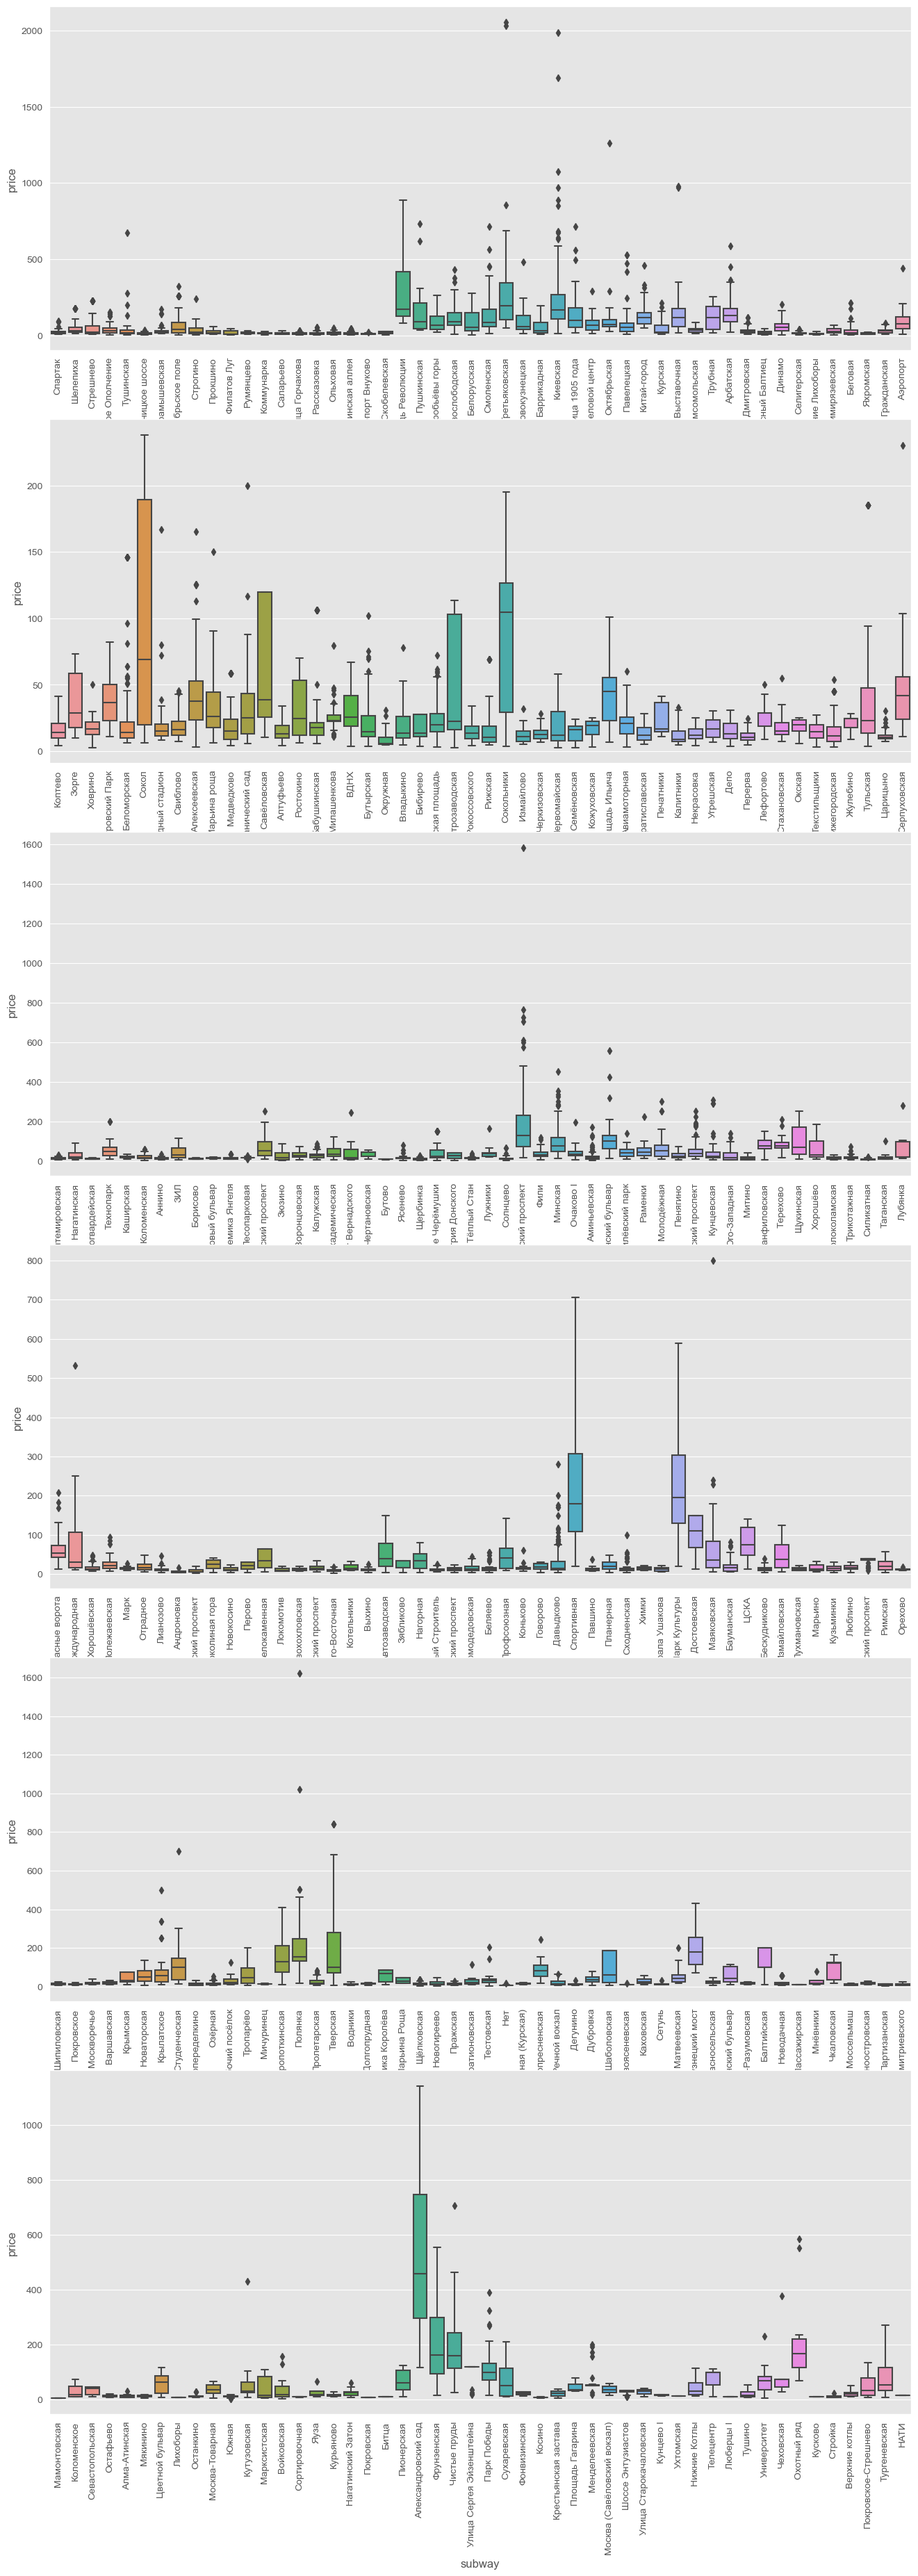

In [1932]:
fig, ax = plt.subplots(6, 1, figsize=(16, 45))
for i in range(6):
    sns.boxplot(x = df.loc[(df['subway'].notnull()) & (df['subway'].isin(subway_list[i*50:i*50+50])), 'subway'], y = df.price/10**6, whis = 2, ax = ax[i], \
                hue_order = np.sort(df.loc[df['subway'].notnull(), 'subway'].unique()));
    ax[i].tick_params(axis='x', rotation=90)
plt.show()

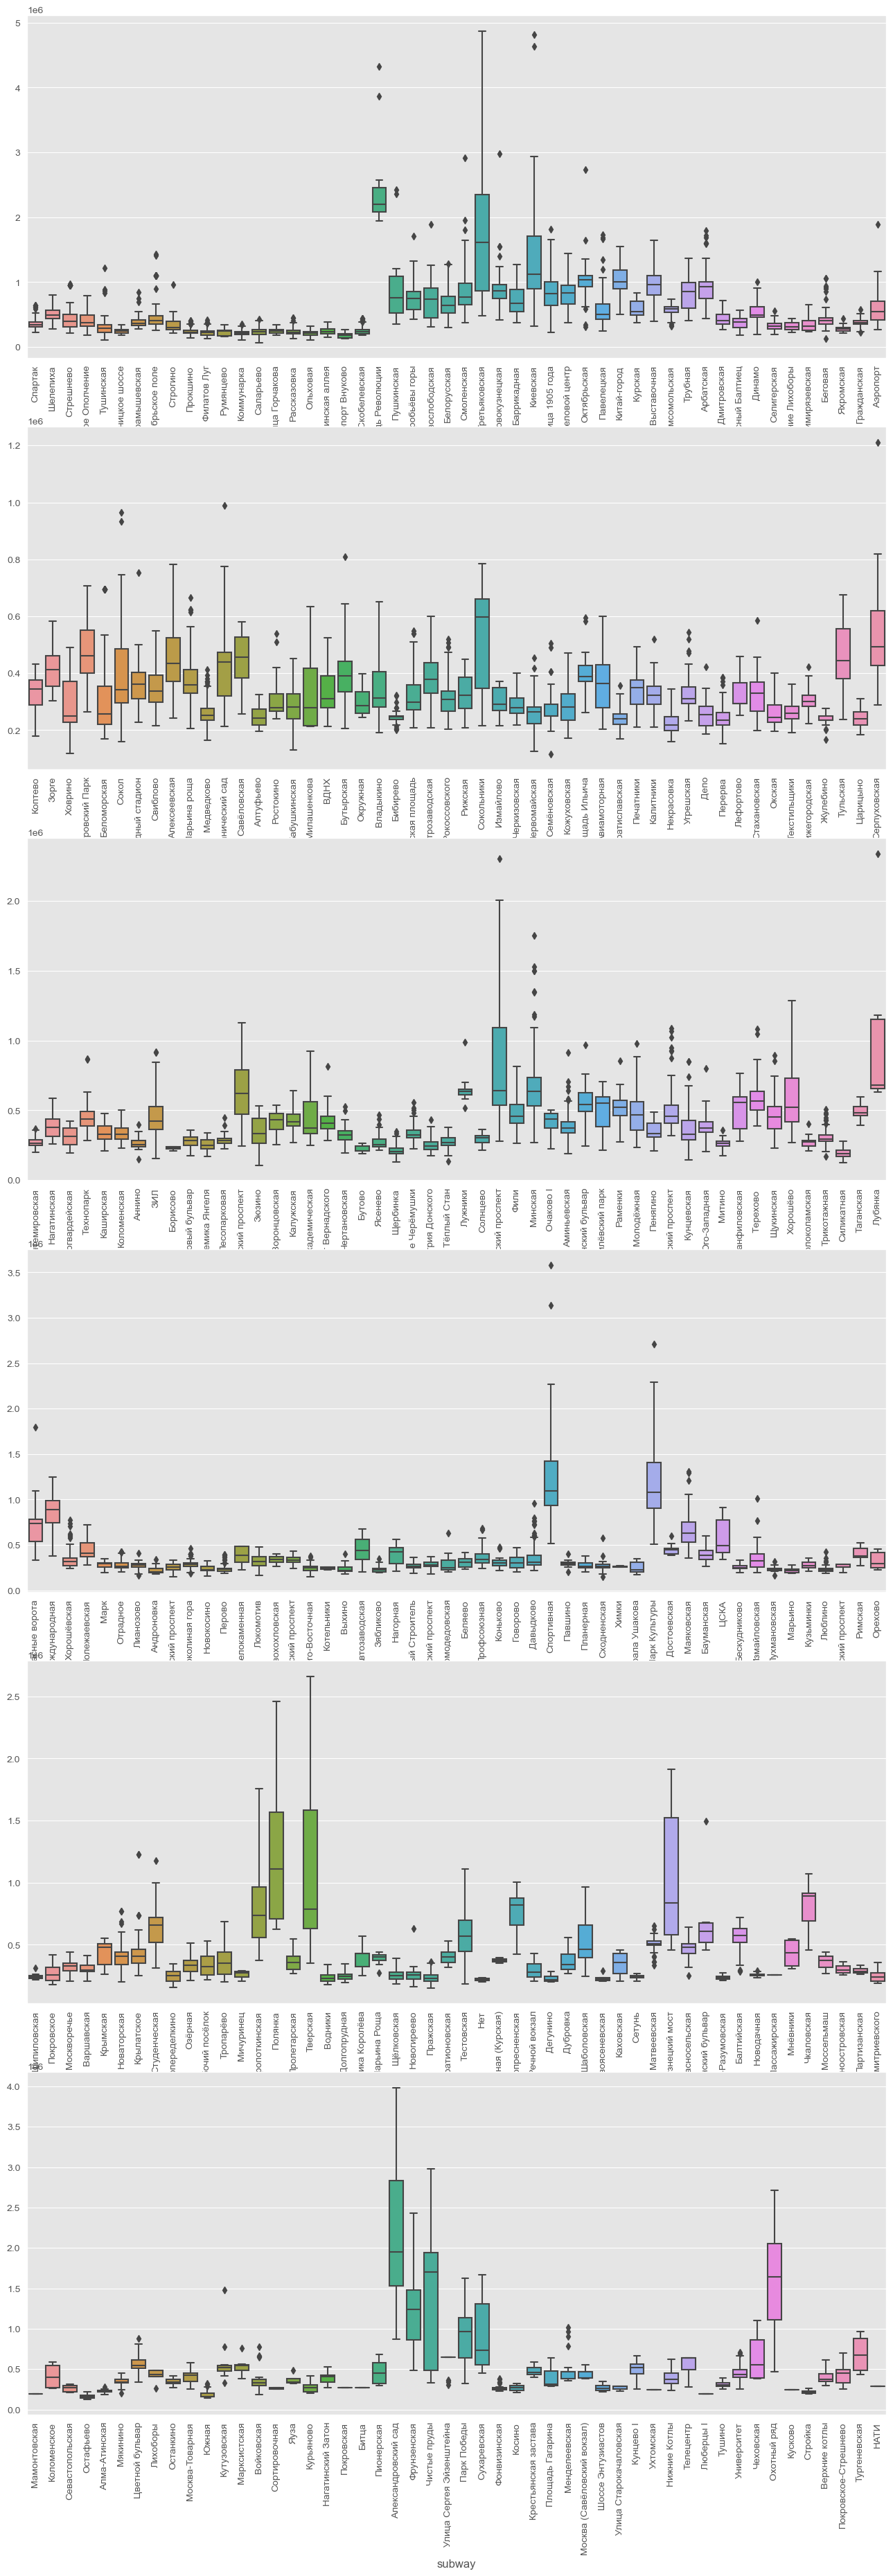

In [1933]:
# и на распределение стоимости квадратного метра от метро

fig, ax = plt.subplots(6, 1, figsize=(16, 45))
for i in range(6):
    sns.boxplot(x = df.loc[(df['subway'].notnull()) & (df['subway'].isin(subway_list[i*50:i*50+50])), 'subway'], y = df.price/df.total_meters, whis = 2, ax = ax[i], \
                hue_order = np.sort(df.loc[df['subway'].notnull(), 'subway'].unique()));
    ax[i].tick_params(axis='x', rotation=90)
plt.show()

Мы видим, что некоторые станции метро так и притягивают "дорогие" квартиры. Но надо еще проверить, нет ли здесь корреляции с округом Моксвы.

### Dist_to_subway: расстояние до ближайшего метро или станции - выделяем расстояние в минутах и способ измерения ###

In [1934]:
df.dist_to_subway.unique()

array(['5 минут пешком', '14 минут пешком', '10 минут пешком',
       '18 минут пешком', '15 минут пешком', '2 минуты на транспорте',
       '20 минут пешком', '9 минут пешком', '11 минут пешком',
       '19 минут пешком', '14 минут на транспорте',
       '7 минут на транспорте', '3 минуты на транспорте',
       '5 минут на транспорте', '6 минут на транспорте',
       '10 минут на транспорте', '11 минут на транспорте',
       '9 минут на транспорте', '12 минут на транспорте',
       '8 минут на транспорте', '13 минут на транспорте',
       '2 минуты пешком', '12 минут пешком', '6 минут пешком',
       '7 минут пешком', '3 минуты пешком', '8 минут пешком',
       '1 минута пешком', '13 минут пешком', '4 минуты пешком',
       '16 минут пешком', '15 минут на транспорте', '17 минут пешком',
       '4 минуты на транспорте', '23 минуты на транспорте',
       '21 минута на транспорте', '1 минута на транспорте',
       '19 минут на транспорте', nan, '30 минут на транспорте',
       '16 минут 

In [1935]:
df['dist_to_subway'].fillna('', inplace=True)

/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/3780158175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_to_subway'].fillna('', inplace=True)


In [1936]:
df['dist_to_subway, min'] = df.dist_to_subway.str.extract('(\d+)')

/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/2556657823.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_to_subway, min'] = df.dist_to_subway.str.extract('(\d+)')


In [1937]:
def get_dist_to_subway_by(x):
    if 'пешком' in x:
        return 'пешком'
    elif 'на транспорте' in x:
        return 'на транспорте'
    else:
        return '';

In [1938]:
df['way_to_subway'] = df['dist_to_subway'].apply(get_dist_to_subway_by)

/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/542624247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['way_to_subway'] = df['dist_to_subway'].apply(get_dist_to_subway_by)


In [1939]:
df['way_to_subway'].value_counts()

пешком           15105
на транспорте     4300
                    10
Name: way_to_subway, dtype: int64

In [1940]:
df[df['way_to_subway'] == '']

rooms           subway dist_to_subway    city           admin_okrug  \
1472       1              Нет                 Москва  НАО (Новомосковский)   
2294       1              Нет                 Москва  НАО (Новомосковский)   
2936       1             ВДНХ                 Москва                  СВАО   
5516       2     Текстильщики                 Москва                  ЮВАО   
7450       2       Щёлковская                 Москва                   ВАО   
8585       2       Щёлковская                 Москва                   ВАО   
12771      4              Нет                 Москва  НАО (Новомосковский)   
14217      4      Дмитровская                 Москва                   САО   
18943      9              Нет                 Москва  НАО (Новомосковский)   
19147      9  Бунинская аллея                 Москва                  ЮЗАО   

                    district street home_number       price  \
1472   Десеновское поселение    1к6         NaN   7200000.0   
2294   Десеновское поселение    1к6         NaN   6400000.0   
2936        р-н Алексеевский      4         NaN  10500000.0   
5516        р-н Текстильщики      4         NaN   9500000.0   
7450           р-н Гольяново    1К1         NaN  11100000.0   
8585           р-н Гольяново    1К1         NaN  11100000.0   
12771  Десеновское поселение    1к4         NaN  15900000.0   
14217      р-н Тимирязевский      1         NaN  29500000.0   
18943  Десеновское поселение    1к1         NaN   7100000.0   
19147       р-н Южное Бутово     15         NaN   4250000.0   

      year_of_construction  ...  kitchen_meters floor floors_count  flat_type  \
1472                  2022  ...             8.0    15           17   Вторичка   
2294                  2022  ...            None     8           17   Вторичка   
2936                  1965  ...             4.0     2            9   Вторичка   
5516                  1964  ...            None     2            9   Вторичка   
7450                  1968  ...             6.0     5            5   Вторичка   
8585                  1968  ...             5.0     2            5   Вторичка   
12771                 2021  ...            20.0     2           14   Вторичка   
14217                 2022  ...            12.0    24           56   Вторичка   
18943                 2021  ...             6.0     4           17   Вторичка   
19147                 1996  ...            None     1           17   Вторичка   

       house_type             wc ceiling class dist_to_subway, min  \
1472         None  1 совмещенный   2,7 м  None                 NaN   
2294         None           None    None  None                 NaN   
2936    Кирпичный   1 раздельный   2,7 м  None                 NaN   
5516    Кирпичный  1 совмещенный    None  None                 NaN   
7450    Панельный   1 раздельный   2,5 м  None                 NaN   
8585    Панельный   1 раздельный  2,64 м  None                 NaN   
12771  Монолитный   1 раздельный    None  None                 NaN   
14217  Монолитный   3 раздельных   3,2 м  None                 NaN   
18943        None           None    None  None                 NaN   
19147  Монолитный  1 совмещенный  2,64 м  None                 NaN   

      way_to_subway  
1472                 
2294                 
2936                 
5516                 
7450                 
8585                 
12771                
14217                
18943                
19147                

[10 rows x 22 columns]

Для Десеновского поселения на транспорте до ближайшего метро порядка 45 минут, проставим так
Для Алексеевского района расстояние до метро пешком не будет превышать 15-20 минут

In [1941]:
df.loc[ (df["district"] == "Десеновское поселение") & (df["dist_to_subway"] == ""), "dist_to_subway, min"] = 45
df.loc[ (df["district"] == "Десеновское поселение") & (df["dist_to_subway"] == ""), "way_to_subway"] = 'на транспорте'

In [1942]:
df.loc[ (df["district"] == "р-н Алексеевский") & (df["dist_to_subway"] == ""), "dist_to_subway, min"] = 15
df.loc[ (df["district"] == "р-н Алексеевский") & (df["dist_to_subway"] == ""), "way_to_subway"] = 'пешком'

df.loc[ (df["district"] == "р-н Гольяново") & (df["dist_to_subway"] == ""), "dist_to_subway, min"] = 30
df.loc[ (df["district"] == "р-н Гольяново") & (df["dist_to_subway"] == ""), "way_to_subway"] = 'пешком'

df.loc[ (df["district"] == "р-н Южное Бутово") & (df["dist_to_subway"] == ""), "dist_to_subway, min"] = 30
df.loc[ (df["district"] == "р-н Южное Бутово") & (df["dist_to_subway"] == ""), "way_to_subway"] = 'пешком'

In [1943]:
assert df.dist_to_subway.isna().sum()==0 # проверяем проверку 
df.drop('dist_to_subway', axis=1, inplace=True)

/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/3988877785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('dist_to_subway', axis=1, inplace=True)


Проверим, есть ли зависимость стоимости квартир от удаленности от метро

In [1944]:
df["dist_to_subway, min"] = df['dist_to_subway, min'].astype(float)

/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/1547164062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dist_to_subway, min"] = df['dist_to_subway, min'].astype(float)


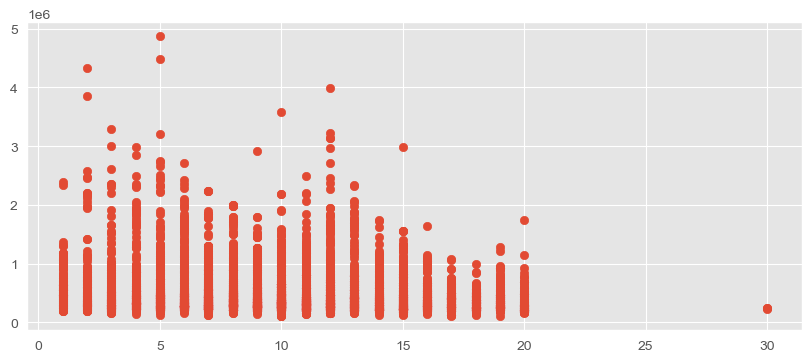

In [1945]:
plt.figure(figsize = (10, 4))
df_walking_to_subway = df[df['way_to_subway']=='пешком']
plt.scatter(df_walking_to_subway['dist_to_subway, min'], df_walking_to_subway.price / df_walking_to_subway.total_meters)
plt.show()

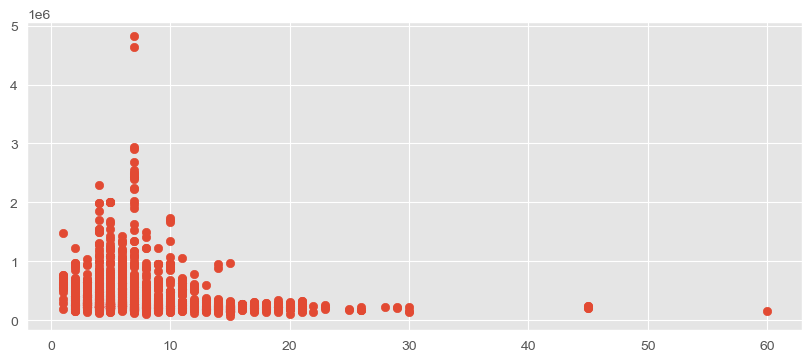

In [1946]:
plt.figure(figsize = (10, 4))
df_walking_to_subway = df[df['way_to_subway']=='на транспорте']
plt.scatter(df_walking_to_subway['dist_to_subway, min'], df_walking_to_subway.price / df_walking_to_subway.total_meters)
plt.show()

/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/2214142999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['by_foot'] = (df['way_to_subway']=='пешком').astype(int)


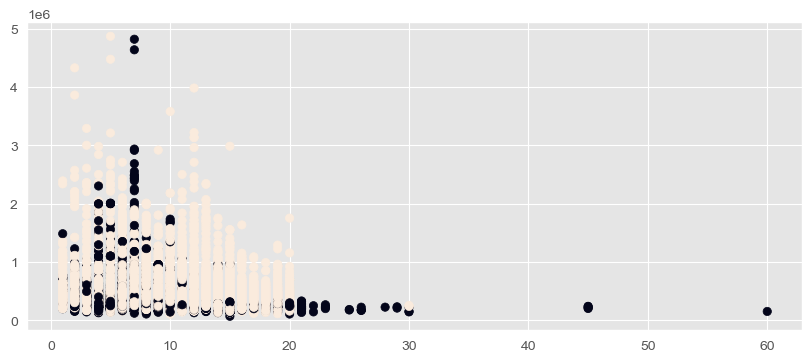

In [1947]:
df['by_foot'] = (df['way_to_subway']=='пешком').astype(int)
plt.figure(figsize = (10, 4))
plt.scatter(df['dist_to_subway, min'], df.price / df.total_meters, c=df['by_foot'])
plt.show()

In [1948]:
to_ohe.add('way_to_subway')
to_scale.add('dist_to_subway, min')

Как видим, есть существенная разница между квартирами в пешей доступности от метро и доступных только на транспорте. При этом при пешей доступности зависимость волнообразная.

### City ###

In [1949]:
to_drop.add('city')

### Аdmin_okrug - административный округ Москвы ###

In [1950]:
df.admin_okrug.value_counts()

СЗАО                    2025
СВАО                    2016
ЦАО                     2000
САО                     1976
НАО (Новомосковский)    1938
ЗАО                     1922
ЮАО                     1915
ВАО                     1903
ЮЗАО                    1858
ЮВАО                    1781
Name: admin_okrug, dtype: int64

In [1951]:
subways_okrug = {
    'Рассказовка':'НАО (Новомосковский)',
    'Саларьево':'ЗАО',
    'Прокшино':'НАО (Новомосковский)',
    'Бунинская аллея':'ЮЗАО',
    'Румянцево':'НАО (Новомосковский)',
    'Коммунарка':'НАО (Новомосковский)',
    'Филатов Луг':'НАО (Новомосковский)',
    'Силикатная':'НАО (Новомосковский)',
    'Щербинка':'НАО (Новомосковский)',
    'Улица Скобелевская':'ЮЗАО',
    'Ольховая':'НАО (Новомосковский)',
    'Улица Горчакова':'ЮЗАО',
    'Тёплый Стан':'ЮЗАО',
    'Новопеределкино':'ЗАО'
}

In [1952]:
df.admin_okrug = df.admin_okrug.fillna(df.subway.map(subways_okrug))
df.dropna(subset=['admin_okrug'], inplace=True)

/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/3608044301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.admin_okrug = df.admin_okrug.fillna(df.subway.map(subways_okrug))
/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/3608044301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['admin_okrug'], inplace=True)


In [1953]:
df[df.admin_okrug.isna()]

Empty DataFrame
Columns: [rooms, subway, city, admin_okrug, district, street, home_number, price, year_of_construction, total_meters, living_meters, kitchen_meters, floor, floors_count, flat_type, house_type, wc, ceiling, class, dist_to_subway, min, way_to_subway, by_foot]
Index: []

[0 rows x 22 columns]

In [1954]:
assert df.admin_okrug.isna().sum()==0

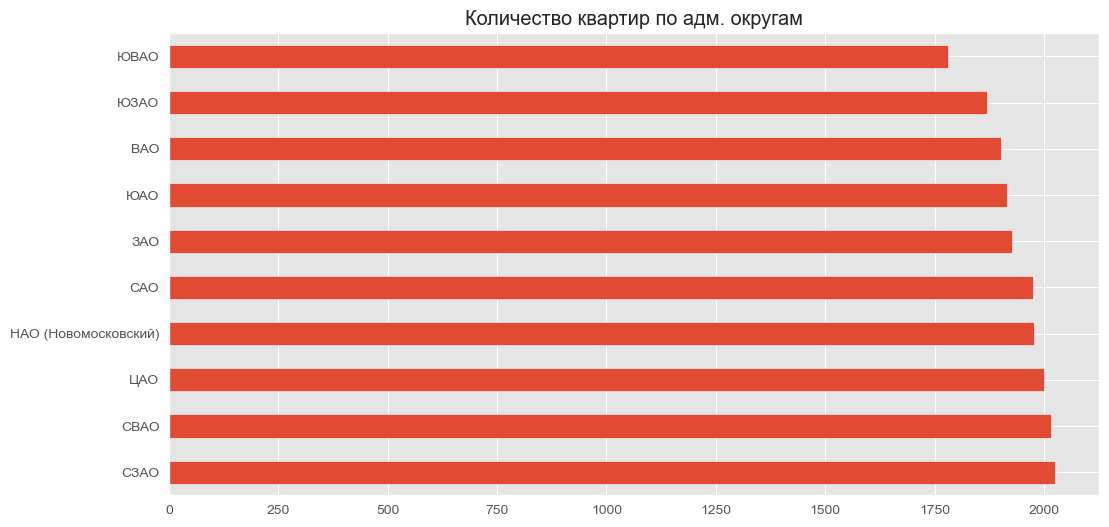

In [1955]:
df['admin_okrug'].value_counts().plot(kind='barh', figsize = (12, 6))
plt.title('Количество квартир по адм. округам')
plt.show()

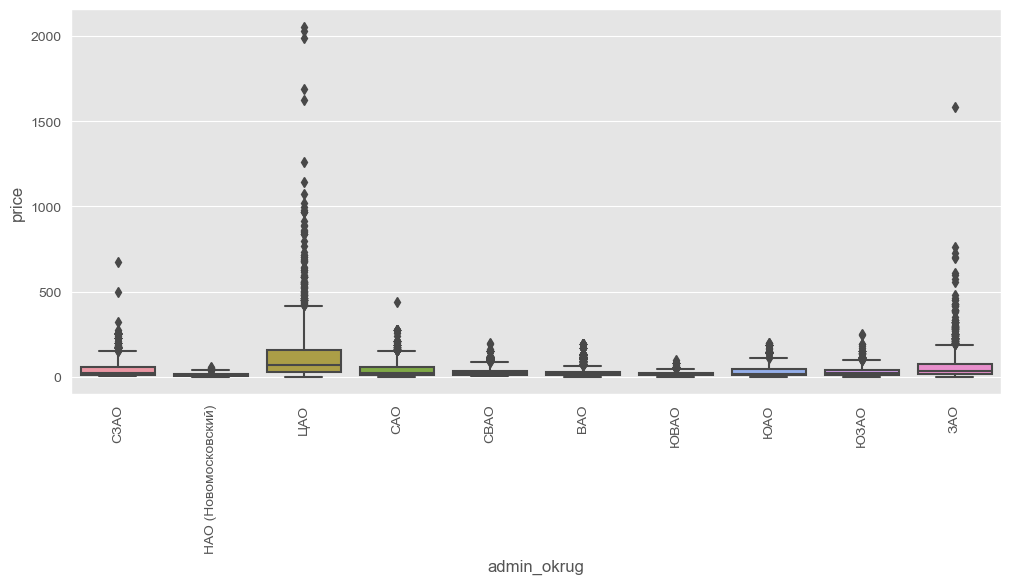

In [1956]:
plt.figure(figsize = (12, 5))
sns.boxplot(x = df.loc[(df['admin_okrug'].notnull()), 'admin_okrug'], y = df.price/10**6, whis = 2, \
                hue_order = np.sort(df.loc[df['admin_okrug'].notnull(), 'admin_okrug'].unique()));
plt.tick_params(axis='x', rotation=90)
plt.show()

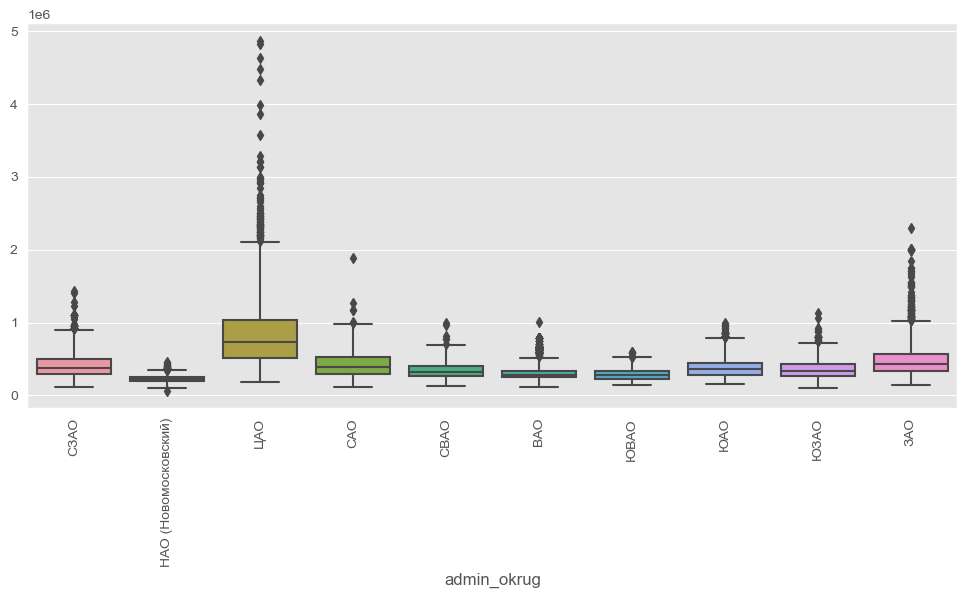

In [1957]:
# Более очевидно для стоимости кв метра

plt.figure(figsize = (12, 5))
sns.boxplot(x = df.loc[(df['admin_okrug'].notnull()), 'admin_okrug'], y = df.price/df.total_meters, whis = 2, \
                hue_order = np.sort(df.loc[df['admin_okrug'].notnull(), 'admin_okrug'].unique()));
plt.tick_params(axis='x', rotation=90)
plt.show()

Видим очевидно выбивающиеся ЦАО, ЗАО и НАО.

Проверим, есть ли различия между станциями метро в пределах одного округа

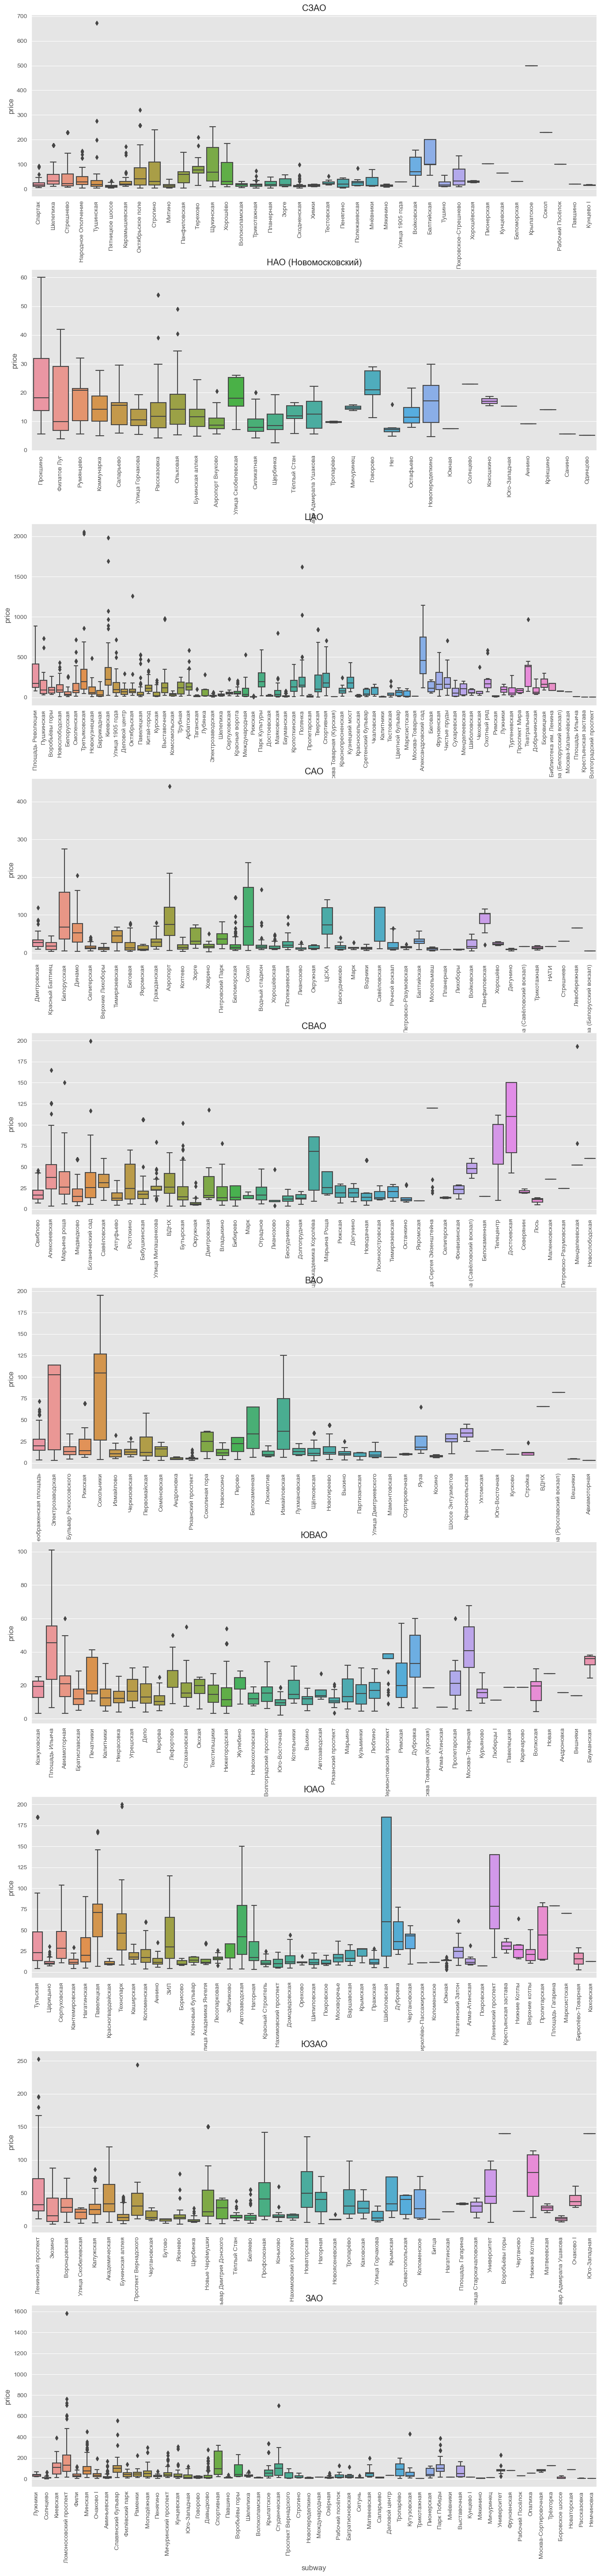

In [1958]:
fig, ax = plt.subplots(10, 1, figsize=(16, 80))
for i in range(10):
    sns.boxplot(x = df.loc[(df['admin_okrug'] == df.admin_okrug.unique()[i]), 'subway'], y = df.price/10**6, whis = 2, ax = ax[i], \
                hue_order = np.sort(df.loc[df['subway'].notnull(), 'subway'].unique()));
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_title(df.admin_okrug.unique()[i])
plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

Видим существенные различия между станциями метро в пределах каждого из округов, поэтому оставляем признак округа вместе с метро.

In [1959]:
to_ohe.add('admin_okrug')

### District - Район в рамках админ округа ###

In [1960]:
subways_district = {
    'Рассказовка':'м. Рассказовка',
    'Саларьево':'м. Саларьево',
    'Прокшино':'м. Прокшино',
    'Бунинская аллея':'м. Бунинская аллея',
    'Румянцево':'м. Румянцево',
    'Коммунарка':'м. Коммунарка',
    'Филатов Луг':'м. Филатов Луг',
    'Силикатная':'Рязановское поселение',
    'Щербинка':'р-н Южное Бутово',
    'Улица Скобелевская':'р-н Южное Бутово',
    'Ольховая':'м. Ольховая',
    'Улица Горчакова':'р-н Южное Бутово'
}

In [1961]:
df.district = df.district.fillna(df.subway.map(subways_district))

/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/3440178779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.district = df.district.fillna(df.subway.map(subways_district))


In [1962]:
districts = list(df.district.unique())

In [1963]:
distrs_random = np.random.randint(len(districts), size=10)

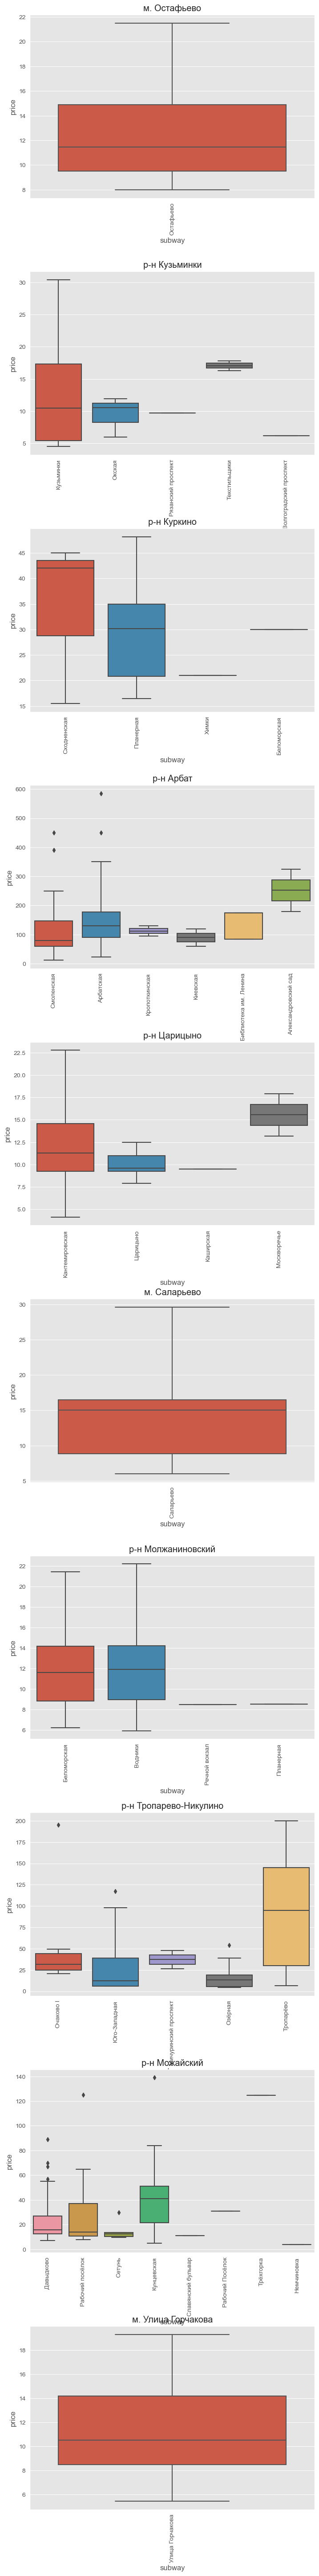

In [1964]:
fig, ax = plt.subplots(10, 1, figsize=(8, 80))
t=0
for i in distrs_random:
    sns.boxplot(x = df.loc[(df['district'] == df.district.unique()[i]), 'subway'], y = df.price/10**6, whis = 2, ax = ax[t], \
                hue_order = np.sort(df.loc[df['subway'].notnull(), 'subway'].unique()));
    ax[t].tick_params(axis='x', rotation=90)
    ax[t].set_title(df.district.unique()[i])
    t = t+1
plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

In [1965]:
df.dropna(subset=['district'], inplace=True)

/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/1757133920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['district'], inplace=True)


Как видим и район города не коррелирует полностью с метро (кроме районов с одной станцией на окраинах). Оставляем параметр для анализа

In [1966]:
to_ohe.add('district')

### street, home_number - номер дома ###

Не будем использовать для трансформации и обучения, но можно было бы использовать для поиска года постройки, например.

In [1967]:
#to_drop.add('street')
#to_drop.add('home_number')

### Rooms - количество комнат ###

In [1968]:
df.rooms.value_counts() # пропусков не должно быть, заполнялось парсером при сборе данных

2    4196
5    4015
4    3125
1    2821
9    2652
3    2579
Name: rooms, dtype: int64

Кажется, что количество комнат должно быть хорошим дескриптором. Количество комнат принимает значения от студии и далее от 1 до 3. Кажется, что можно оставить это значение ординальным признаком, т.к. количество комнат обычно соотвествует большему метражу. Давайте проверим как соотносятся площади, кол-во комнат и стоимость жилья.

### Year_of_construction ###

In [1969]:
df['year_of_construction'].isna().sum()

704

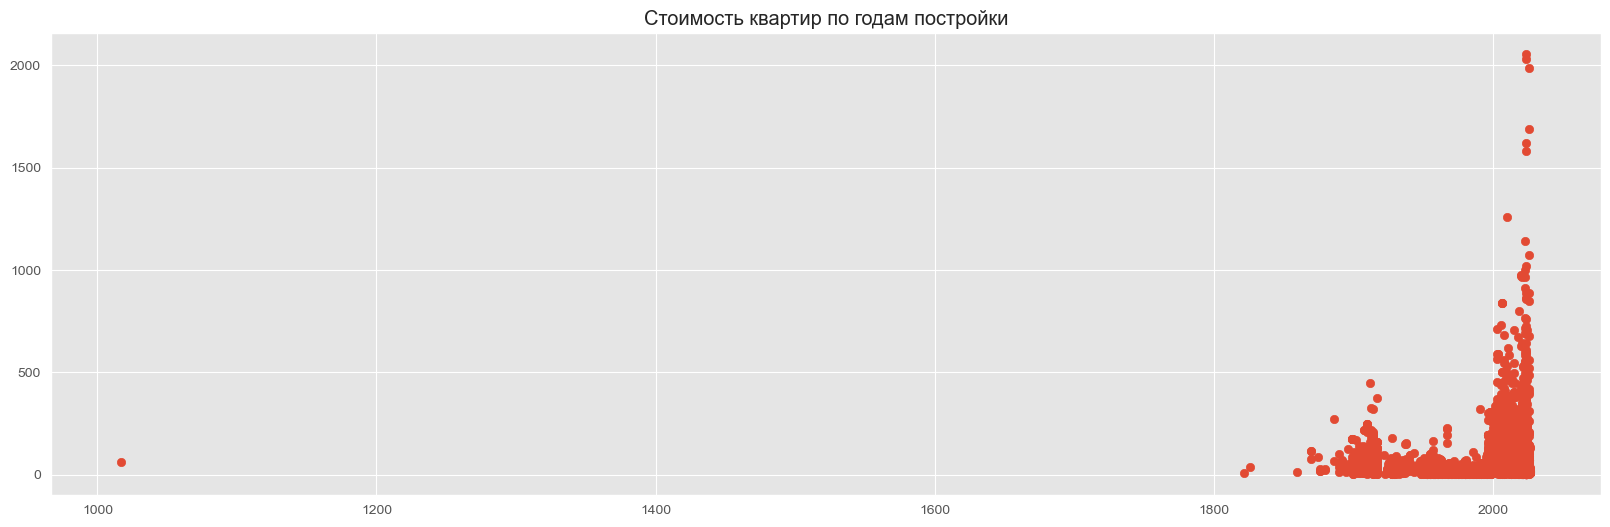

In [1970]:
plt.figure(figsize = (20, 6))
plt.scatter(df['year_of_construction'], df.price // 10**6)
plt.title('Стоимость квартир по годам постройки')
plt.show()

In [1971]:

#av_data = av_data.drop(axis = 0, index = av_data[av_data.address.isnull()].index)
df = df.drop(axis = 0, index = df[df['year_of_construction']<1800].index)

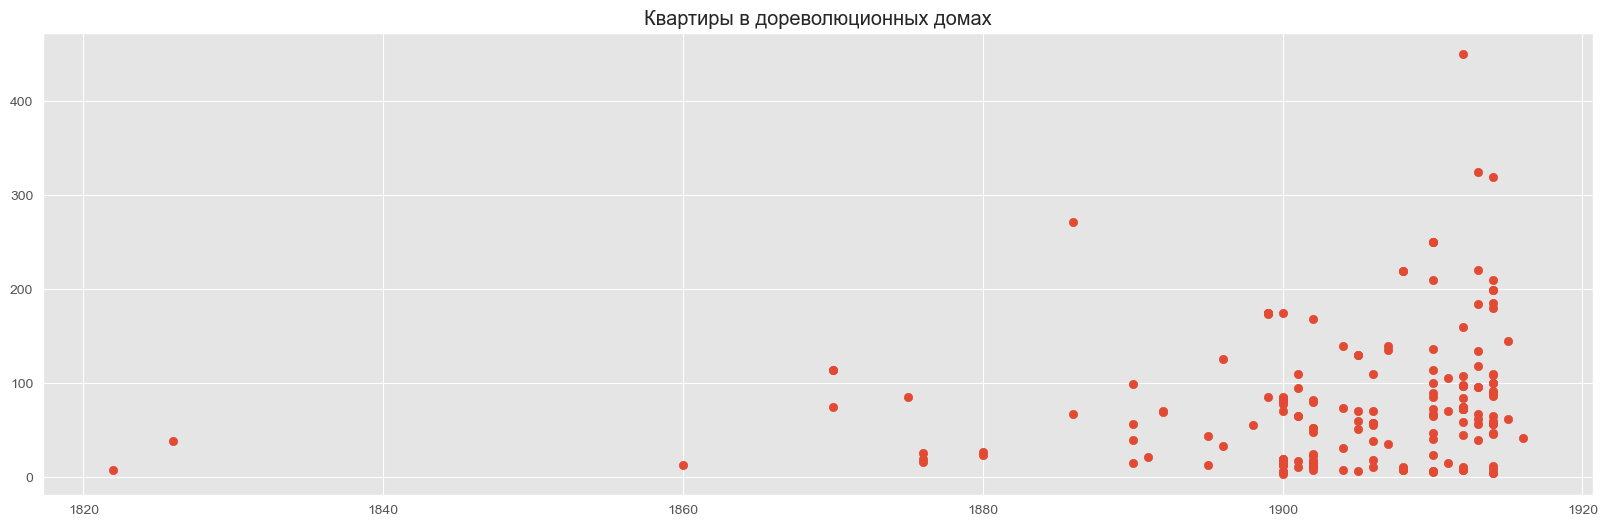

In [1972]:
plt.figure(figsize = (20, 6))
df_beforerevolt = df[df['year_of_construction'] < 1917]
plt.scatter(df_beforerevolt['year_of_construction'], df_beforerevolt.price // 10**6)
plt.title('Квартиры в дореволюционных домах')
plt.show()

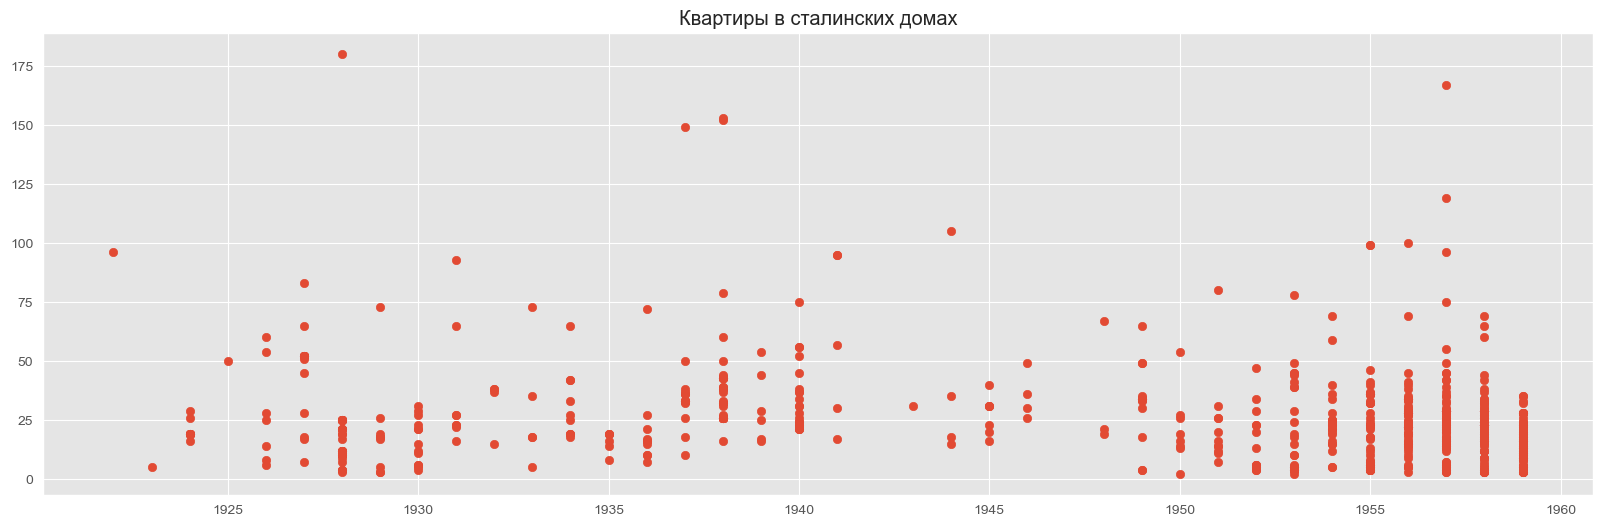

In [1973]:
plt.figure(figsize = (20, 6))
df_stalin = df[ (df['year_of_construction'] < 1960) & (df['year_of_construction'] > 1917 )]
plt.scatter(df_stalin['year_of_construction'], df_stalin.price // 10**6)
plt.title('Квартиры в сталинских домах')
plt.show()

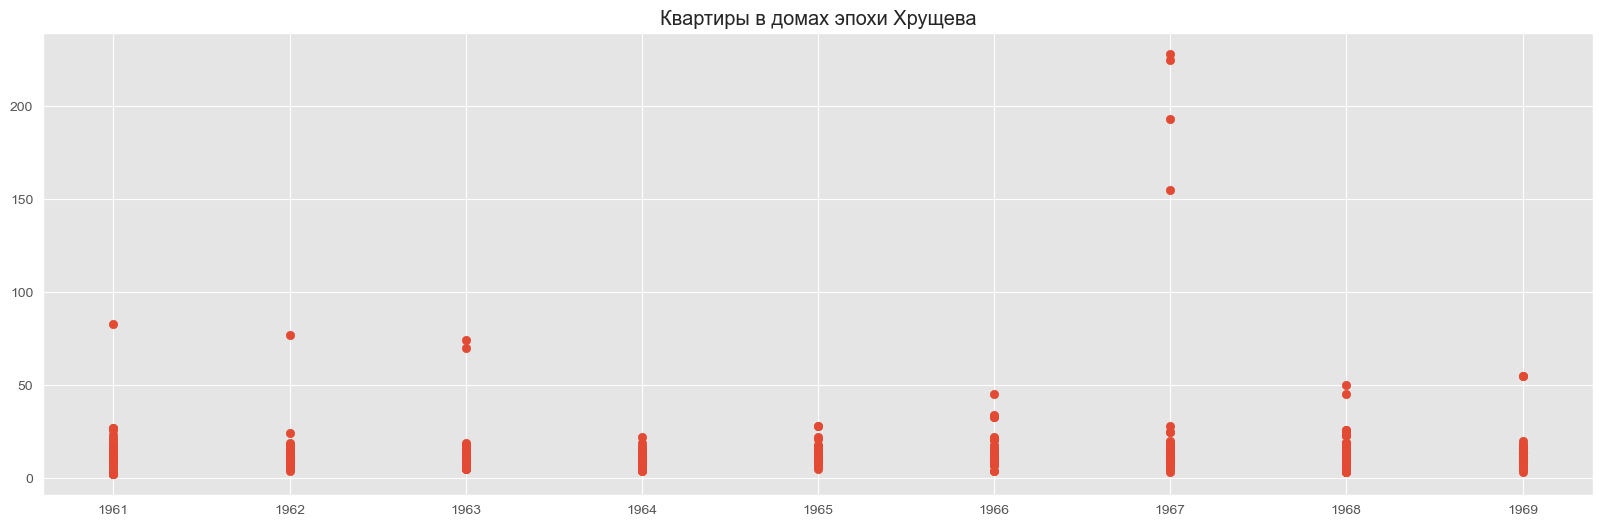

In [1974]:
plt.figure(figsize = (20, 6))
df_khrushev = df[ (df['year_of_construction'] < 1970) & (df['year_of_construction'] > 1960 )]
plt.scatter(df_khrushev['year_of_construction'], df_khrushev.price // 10**6)
plt.title('Квартиры в домах эпохи Хрущева')
plt.show()

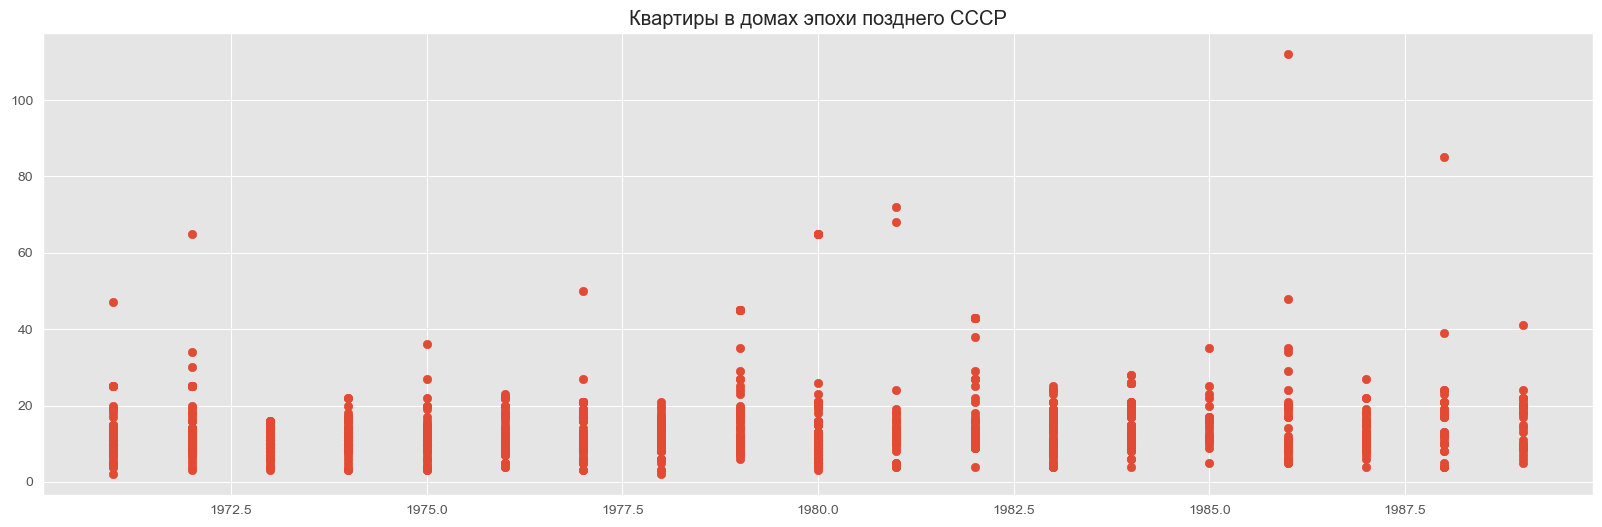

In [1975]:
plt.figure(figsize = (20, 6))
df_lateussr = df[ (df['year_of_construction'] > 1970) & (df['year_of_construction'] < 1990 )]
plt.scatter(df_lateussr['year_of_construction'], df_lateussr.price // 10**6)
plt.title('Квартиры в домах эпохи позднего СССР')
plt.show()

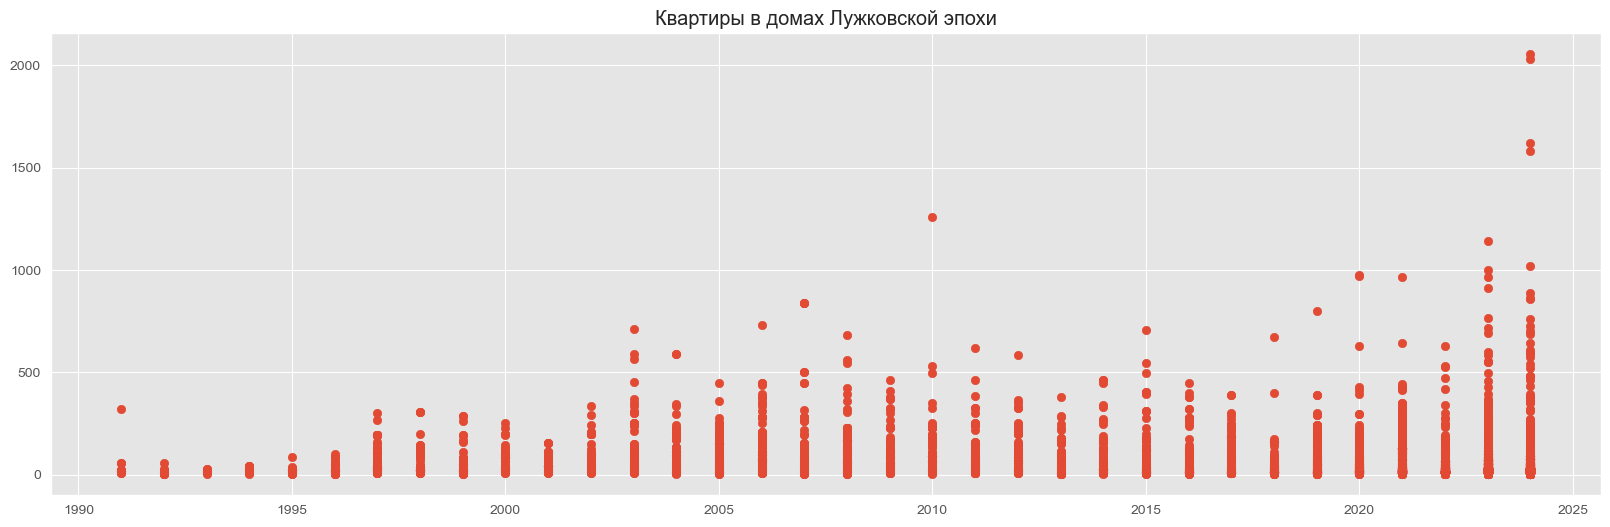

In [1976]:
plt.figure(figsize = (20, 6))
df_nineties = df[ (df['year_of_construction'] > 1990) & (df['year_of_construction'] < 2025 )]
plt.scatter(df_nineties['year_of_construction'], df_nineties.price // 10**6)
plt.title('Квартиры в домах Лужковской эпохи')
plt.show()

Можно предположить, что потребителям начинает быть важен конкретный возраст дома, когда этот возраст становится ближе к 10 годам. В остальные периоды мы видим всплески в дореволюционной и сталинской архитектуре, хрущевско-брежневская эпоха плоская, затем с 2000 года становится чем новее, тем дороже (вероятно за счет дополнительных удобств: двор без машин, удобные подъезды и тд.

In [1977]:
### №1 Функция возвращает наиболее часто встречаемое значение в колонке to_find среди домов с тем же адресом, что и x
def find_something(x, to_find):
    if x.loc['home_number'] != '0': # Проводим поиск только для адресов с номером дома
        if df[(df.street == x.loc['street']) & (df.home_number == x.loc['home_number'])][to_find] \
        .dropna().empty == False: # Инициализируем поиск, только если есть дома с таким же адресом
            return(df[(df.street == x.loc['street']) & (df.home_number == x.loc['home_number'])][to_find] \
                   .dropna().value_counts().idxmax())
        else:
            return np.nan
    else:
        return np.nan

In [1978]:
# Попробуем найти дома по тем же адресам с указанным годом
df.loc[df['year_of_construction'].isnull(), 'year_of_construction'] = \
df[df['year_of_construction'].isnull()].apply(find_something, **{'to_find' : 'year_of_construction'}, axis = 1)

In [1979]:
df = df[df['year_of_construction'].notna()] # Убираем кого не смогли найти

In [1980]:
df[df['year_of_construction']==df['year_of_construction'].min()] # интересно, что за самый старый дом

rooms           subway    city admin_okrug      district  \
20089      9  Цветной бульвар  Москва         ЦАО  р-н Тверской   

                       street home_number      price year_of_construction  \
20089  Садовая-Каретная улица        20С1  8000000.0                 1822   

       total_meters  ... floor floors_count  flat_type  house_type  \
20089          17.0  ...     2            4   Вторичка   Кирпичный   

                  wc ceiling class dist_to_subway, min way_to_subway  by_foot  
20089  1 совмещенный     3 м  None                12.0        пешком        1  

[1 rows x 22 columns]

In [1981]:
to_encode.add('year_of_construction')

### total_meters, living_meters, kitchen_meters ###

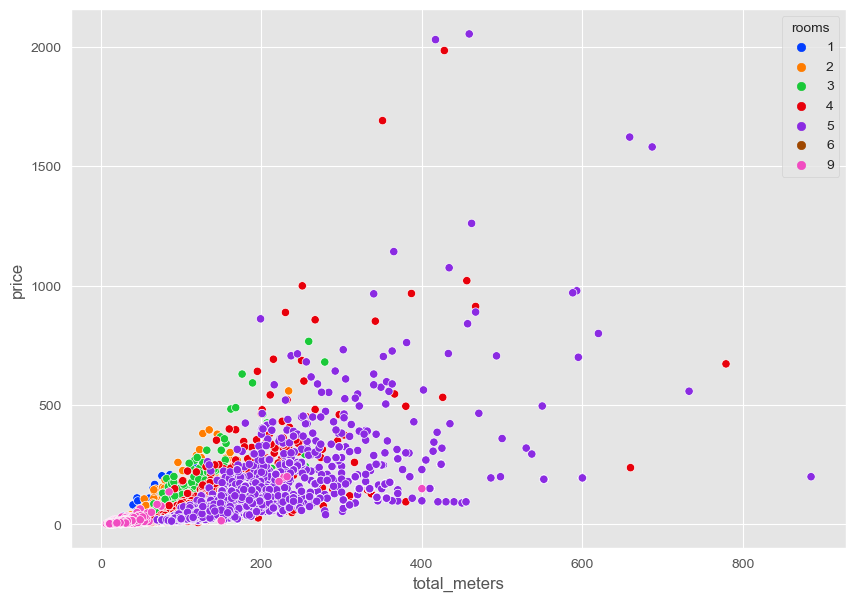

In [1982]:
f, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x = df.loc[:, 'total_meters'], y = df.loc[:, 'price']/10**6, hue = df.rooms, \
                palette = 'bright', hue_order = [1, 2, 3, 4, 5, 6, 9]);

In [1983]:
df.dtypes

rooms                     int64
subway                   object
city                     object
admin_okrug              object
district                 object
street                   object
home_number              object
price                   float64
year_of_construction     object
total_meters            float64
living_meters            object
kitchen_meters           object
floor                     int64
floors_count              int64
flat_type                object
house_type               object
wc                       object
ceiling                  object
class                    object
dist_to_subway, min     float64
way_to_subway            object
by_foot                   int64
dtype: object

In [1984]:
df.living_meters = df.living_meters.astype(float)
df.kitchen_meters = df.kitchen_meters.astype(float)

In [1985]:
def multi_plot(n_cols, n_rows, plot_data, x, palette = 'tab10', figsize = (20,10), bins = 50, binwidth = None, \
               legend = False):
    fig, ax = plt.subplots(ncols=n_cols, nrows = n_rows, figsize = figsize)
    fig.tight_layout()
    sns.set_palette(palette)
    fig.subplots_adjust(top=0.95)
    i = 0
    j = 0
    if bins != 50:
        while True:
            sns.histplot(data = plot_data, x = x[j + n_cols*i], ax = ax[i, j], bins = bins_list[j+n_cols*i], \
                         legend = legend, multiple = 'stack', binwidth = binwidth)
            if j == (n_cols - 1) and i == (n_rows - 1):
                break
            elif j < (n_cols - 1):
                j = j + 1
            else:
                j = 0
                i = i + 1
    elif x.shape[0] > 3000:
        while True:
            sns.histplot(data = plot_data, x = x, ax = ax[i, j], bins = bins, 
                         legend = legend, hue = plot_data.columns[j + n_cols*i], binwidth = binwidth, multiple = 'stack')
            if j == (n_cols - 1) and i == (n_rows - 1):
                break
            elif j < (n_cols - 1):
                j = j + 1
            else:
                j = 0
                i = i + 1
    else:
        while True:
            sns.histplot(data = plot_data, x = x[j + n_cols*i], ax = ax[i, j], bins = bins, legend = legend, \
                         binwidth = binwidth, multiple = 'stack')
            if j == (n_cols - 1) and i == (n_rows - 1):
                break
            elif j < (n_cols - 1):
                j = j + 1
            else:
                j = 0
                i = i + 1

/Users/max/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


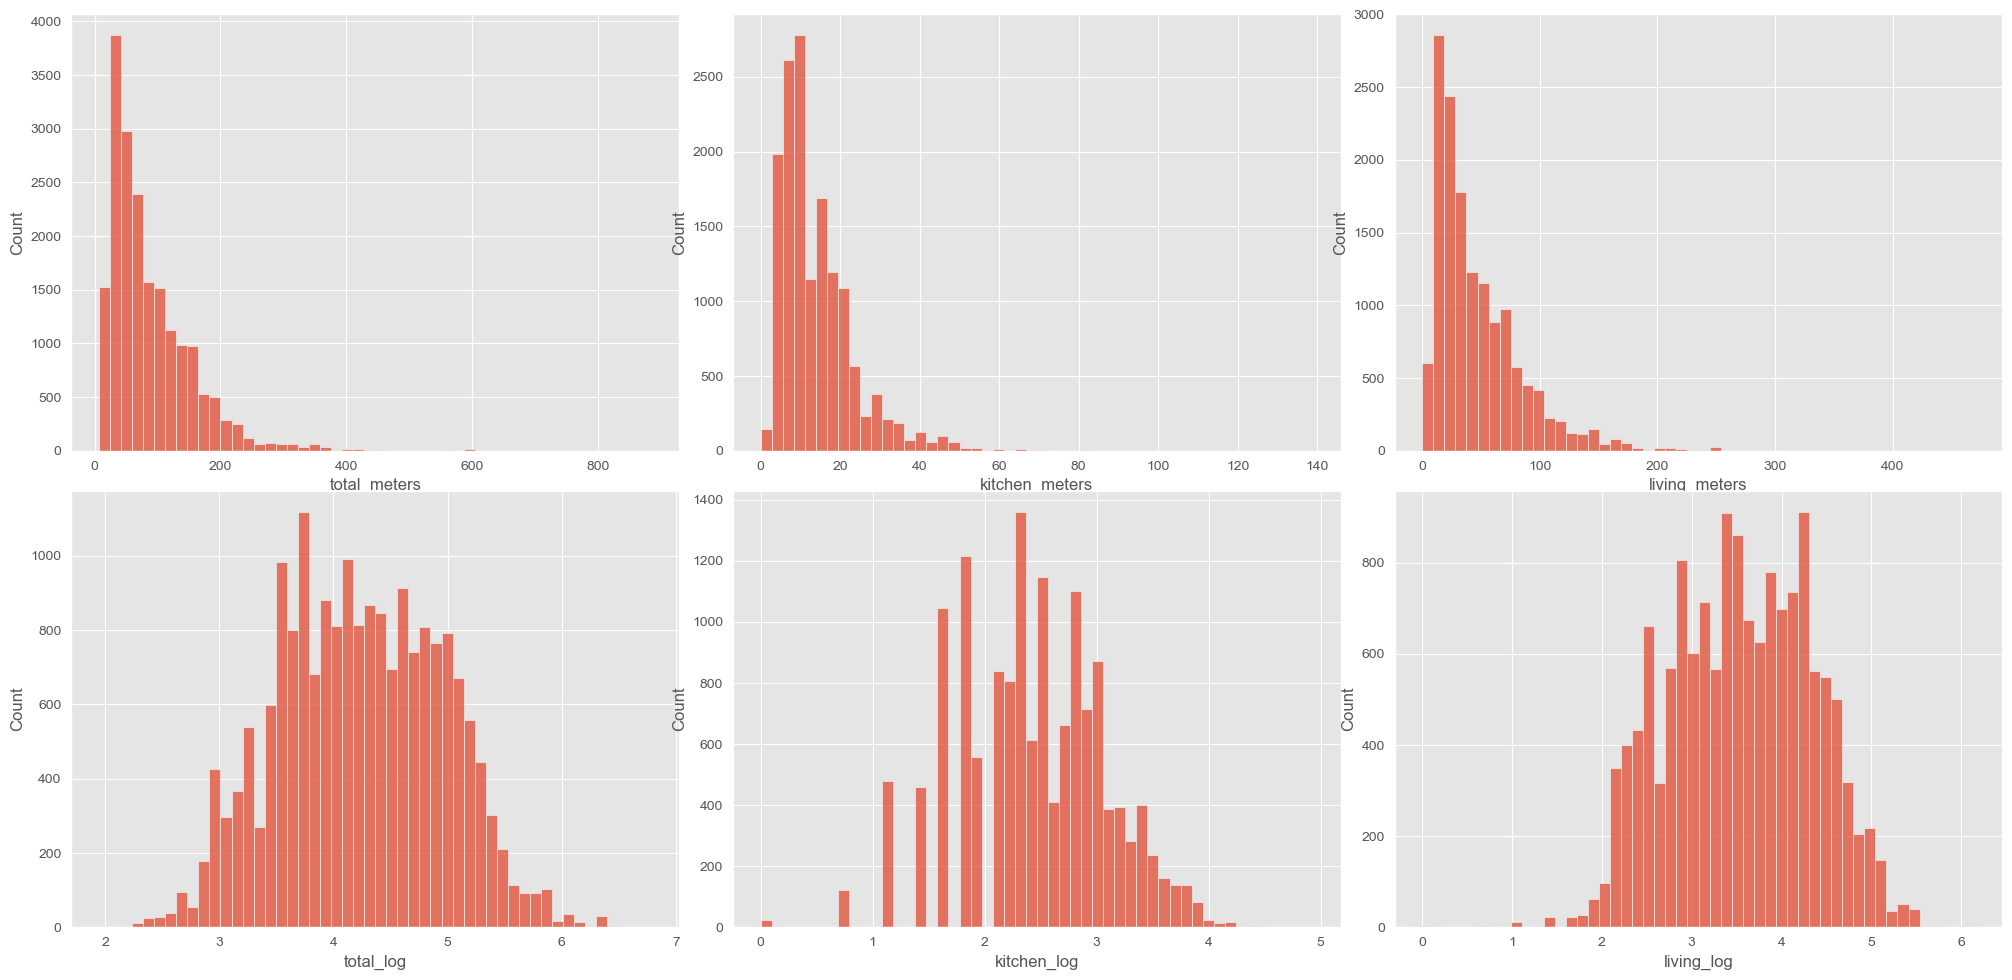

In [1986]:
forplott = pd.concat([df, pd.DataFrame({'total_log' : np.log(df.total_meters),
                                    'kitchen_log' : np.log(df.kitchen_meters),
                                    'living_log' : np.log(df.living_meters)})], axis = 1)\
.loc[:, ['total_meters', 'kitchen_meters', 'living_meters', 'total_log', 'kitchen_log', 'living_log']]
multi_plot(3, 2, forplott, forplott.columns)

/Users/max/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/max/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/max/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/max/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


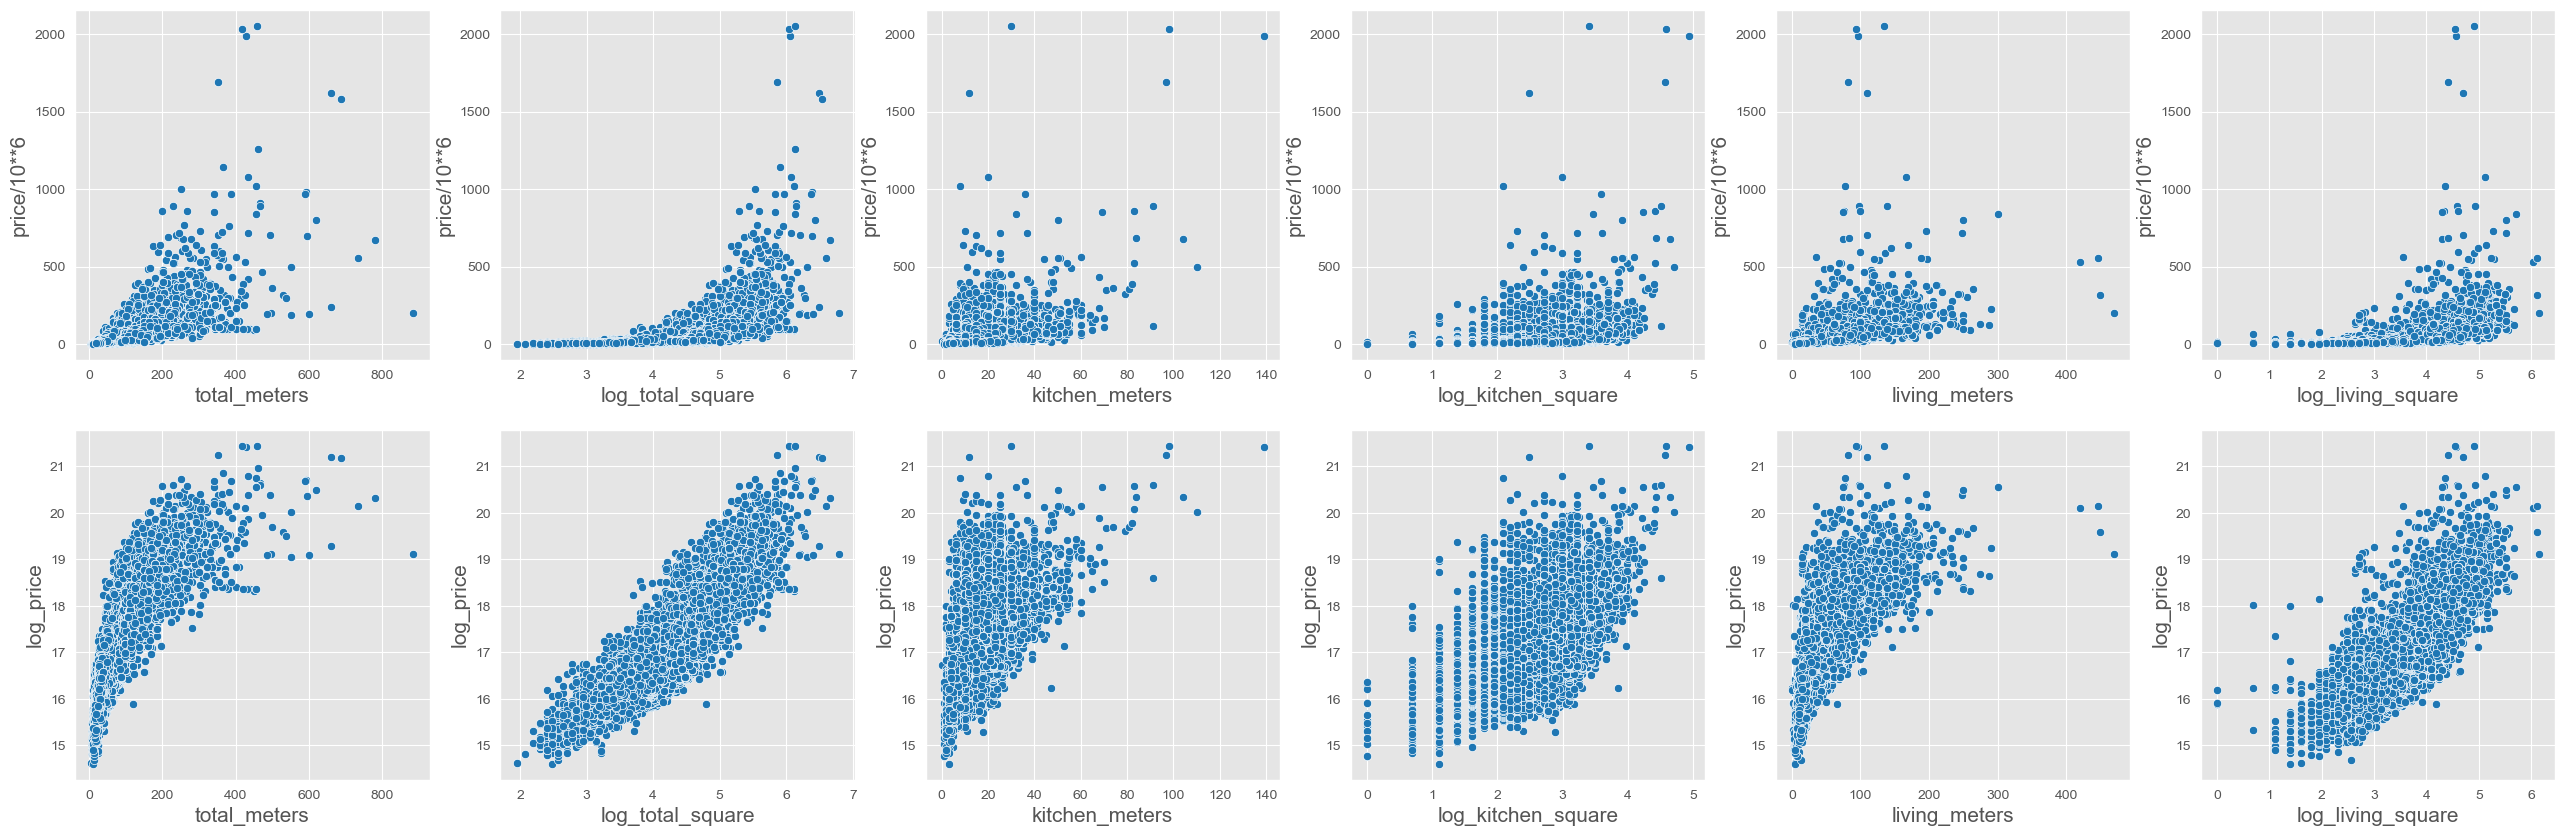

In [1987]:
fig, ax = plt.subplots(ncols = 6, nrows = 2, figsize = (32,10))
sns.set_palette('tab10')
i = 0
j = 0
namess = ['', 'log_total_square','', 'log_kitchen_square','', 'log_living_square']
while True:
    if i == 0:
        y_scat = df.price/10**6
        ax[i, j].set_ylabel('price/10**6', fontsize = 15)
    else:
        y_scat = np.log(df.price)
        ax[i, j].set_ylabel('log_price', fontsize = 15)
    
    if j < 2:
        x_scat = df.total_meters
        ax[i, j].set_xlabel('total_meters', fontsize = 15)
    elif j < 4:
        x_scat = df.kitchen_meters
        ax[i, j].set_xlabel('kitchen_meters', fontsize = 15)
    else:
        x_scat = df.living_meters 
        ax[i, j].set_xlabel('living_meters', fontsize = 15)
    if j % 2 == 1:
        x_scat = np.log(x_scat)
        ax[i, j].set_xlabel(namess[j], fontsize = 15)

        

    sns.scatterplot(x = x_scat, y = y_scat, ax = ax[i, j])
    if j == (6 - 1) and i == (2 - 1):
        break
    elif j < (6 - 1):
        j = j + 1
    else:
        j = 0
        i = i + 1
plt.show()

In [1988]:
df['living_meters'][ (df['living_meters'].isna()) & (df['kitchen_meters'].notna())] = df['total_meters'] - df['kitchen_meters']


/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/315330359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['living_meters'][ (df['living_meters'].isna()) & (df['kitchen_meters'].notna())] = df['total_meters'] - df['kitchen_meters']


In [1989]:
df['kitchen_meters'][ (df['kitchen_meters'].isna()) & (df['living_meters'].notna())] = df['total_meters'] - df['living_meters']

/var/folders/38/z6_rytjx189692qlvsv8vz140000gn/T/ipykernel_9784/2764405124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kitchen_meters'][ (df['kitchen_meters'].isna()) & (df['living_meters'].notna())] = df['total_meters'] - df['living_meters']


In [1990]:
df[['total_meters', 'living_meters', 'kitchen_meters', 'rooms']][(df['living_meters'].isna()) | (df['kitchen_meters'].isna()) ]

total_meters  living_meters  kitchen_meters  rooms
0              37.0            NaN             NaN      1
3              32.0            NaN             NaN      1
5              31.0            NaN             NaN      1
6              31.0            NaN             NaN      1
9              29.0            NaN             NaN      1
...             ...            ...             ...    ...
21243          38.0            NaN             NaN      9
21245          32.0            NaN             NaN      9
21247          27.0            NaN             NaN      9
21255          35.0            NaN             NaN      9
21289          24.0            NaN             NaN      9

[3463 rows x 4 columns]

Для студий давайте обозначим абсолютно минимальную площадь для кухонь: 2мкв. Это скорее уже зона готовки, а не кухня.

In [1991]:
df.loc[(df["rooms"] == 9) & df.kitchen_meters.isna(), "kitchen_meters"] = 2.0

Для многокомнатных давайте возьмем медианную площадь кухни

In [1992]:
#df.loc[(df["rooms"] == 1) & df.kitchen_meters.isna(), "kitchen_meters"] = 
df.loc[(df["rooms"] == 1) & df.kitchen_meters.isna(), "kitchen_meters"] = df[(df["rooms"] == 1) & df.kitchen_meters.notna()]['kitchen_meters'].median()
df.loc[(df["rooms"] == 2) & df.kitchen_meters.isna(), "kitchen_meters"] = df[(df["rooms"] == 2) & df.kitchen_meters.notna()]['kitchen_meters'].median()
df.loc[(df["rooms"] == 3) & df.kitchen_meters.isna(), "kitchen_meters"] = df[(df["rooms"] == 3) & df.kitchen_meters.notna()]['kitchen_meters'].median()
df.loc[(df["rooms"] == 4) & df.kitchen_meters.isna(), "kitchen_meters"] = df[(df["rooms"] == 4) & df.kitchen_meters.notna()]['kitchen_meters'].median()
df.loc[(df["rooms"] == 5) & df.kitchen_meters.isna(), "kitchen_meters"] = df[(df["rooms"] == 5) & df.kitchen_meters.notna()]['kitchen_meters'].median()
df.loc[(df["rooms"] == 6) & df.kitchen_meters.isna(), "kitchen_meters"] = df[(df["rooms"] == 6) & df.kitchen_meters.notna()]['kitchen_meters'].median()

df.loc[(df["rooms"] == 9) & df.kitchen_meters.isna(), "kitchen_meters"] = 2.0

In [1993]:
to_drop.add('living_meters')
to_log.add('total_meters')
to_log.add('kitchen_meters')

Проверим, есть ли в данных "Евродвушки" / "Евротрешки"

In [1994]:
df['is_euro'] = df['kitchen_meters'] > df['living_meters']

Есть ли разница между квартирами с гостиной-кухней и обычными кухнями?

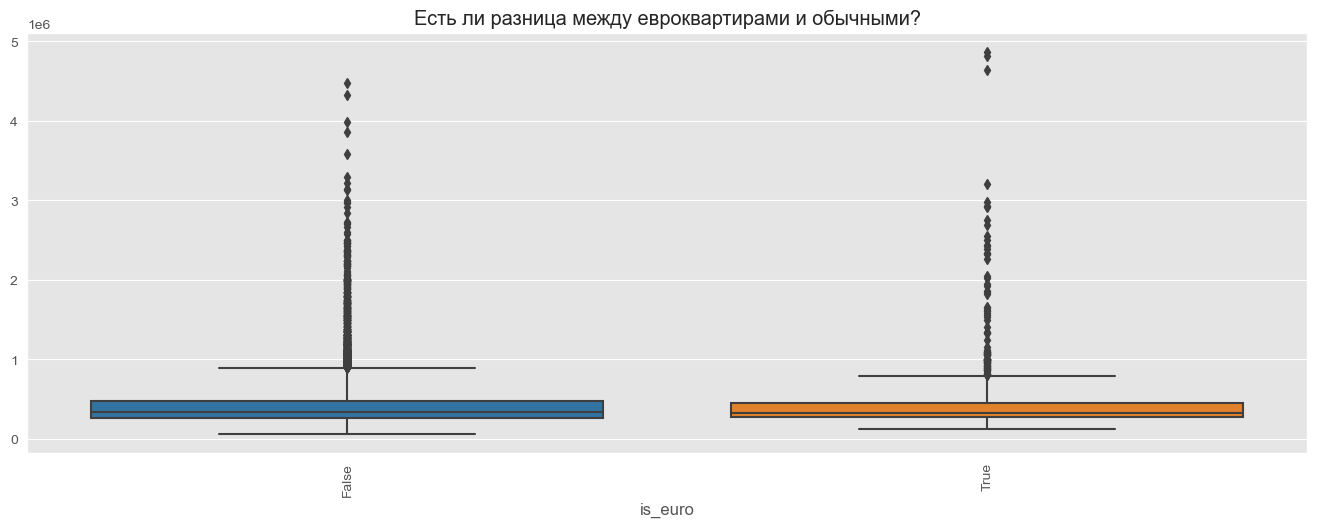

In [1995]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.boxplot(x = df.loc[:, 'is_euro'], y = df.price/df.total_meters, whis = 2)
ax.tick_params(axis='x', rotation=90)
ax.set_title("Есть ли разница между евроквартирами и обычными?")
plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

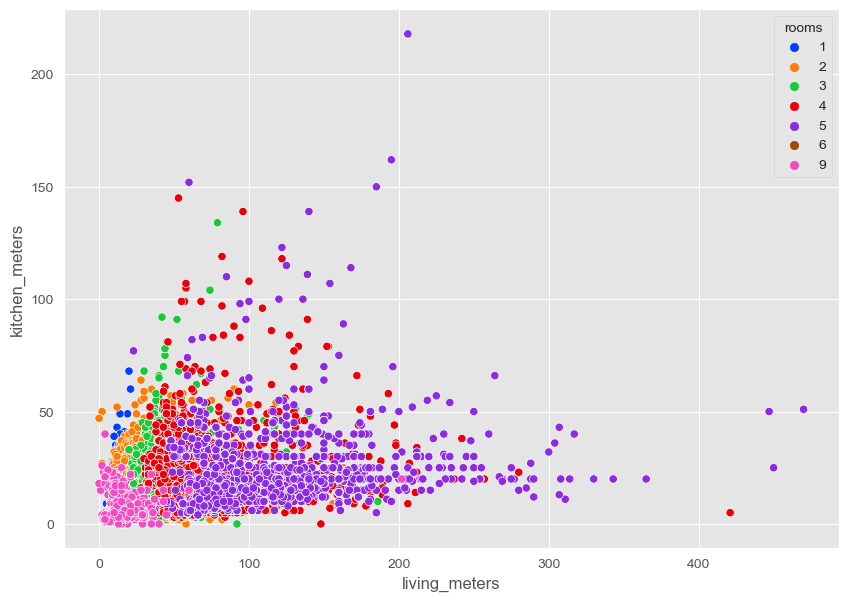

In [1996]:
f, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x = df.loc[:, 'living_meters'], y = df.loc[:, 'kitchen_meters'], hue = df.rooms, \
                palette = 'bright', hue_order = [1, 2, 3, 4, 5, 6, 9]);

### floor, floors_count: выделяем этаж квартиры и максимальный этаж дома ###

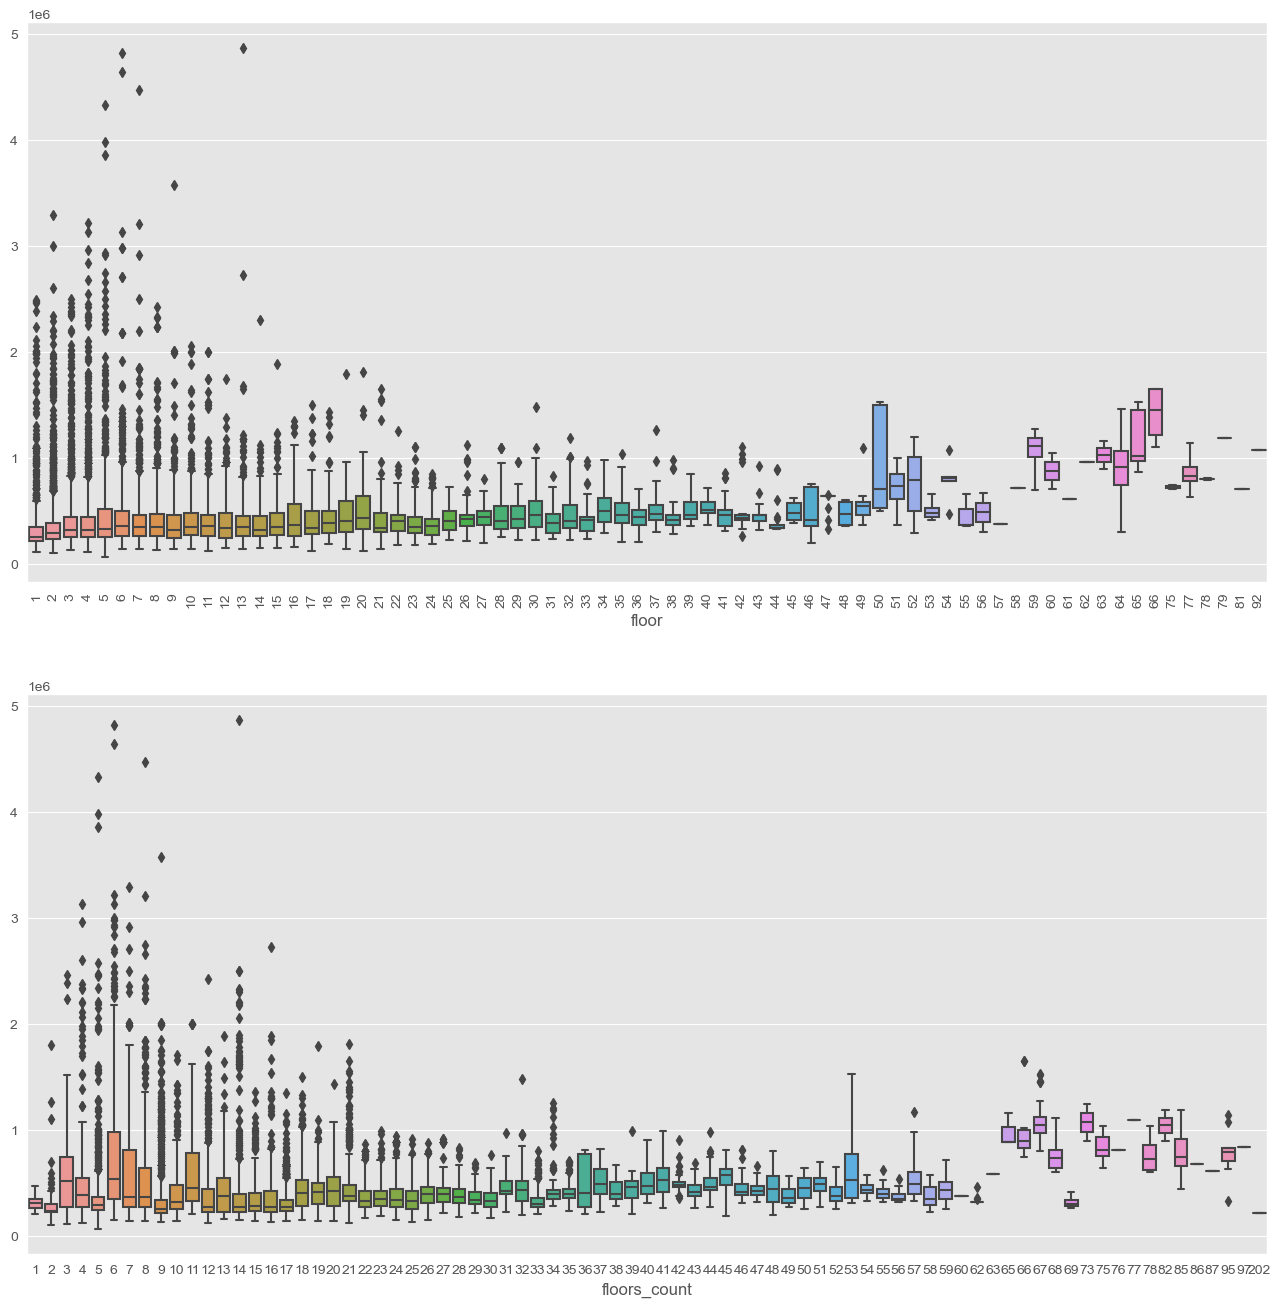

In [1997]:
t = 0
fig, ax = plt.subplots(2, 1, figsize=(16, 16))
for i in ['floor', 'floors_count']:
    sns.boxplot(x = df.loc[df[i].notnull(), i], y = df.price/df.total_meters, whis = 2, ax = ax[t], \
                hue_order = np.sort(df.loc[df[i].notnull(), i].unique()));
    if t in [0, 5]:
        ax[t].tick_params(axis='x', rotation=90)
    t += 1
plt.show()

Кажется, что можно выделить несколько блоков: квартиры на первых этажах (1-2, обычные этажи: 3-15, 15-30 и квартиры в небоскребах: выше 30го). При этом квартиры именно в небоскребах (более 60 этажей) будут существенно дороже. 

In [1998]:
df['is_skyscraper'] = df['floors_count'] > 60

In [1999]:
def get_floor_type (row):
    if row['floor'] < 3 :
        return 'ground'
    elif  3 <= row['floor'] < 15:
        return 'usual'
    elif 15 <= row['floor'] < 30:
        return 'view'
    elif 30 <= row['floor']:
        return 'sky'
    return 'other'

In [2000]:
df['floor_type'] = df.apply (lambda row: get_floor_type(row), axis=1)

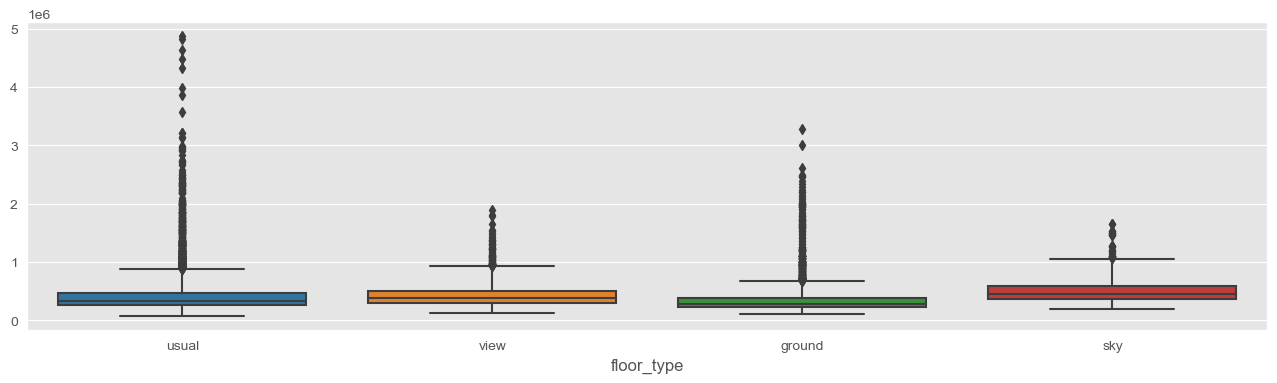

In [2001]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.boxplot(x = df.loc[df['floor_type'].notnull(), 'floor_type'], y = df.price/df.total_meters, whis = 2, \
                hue_order = np.sort(df.loc[df['floor_type'].notnull(), i].unique()));
plt.show()

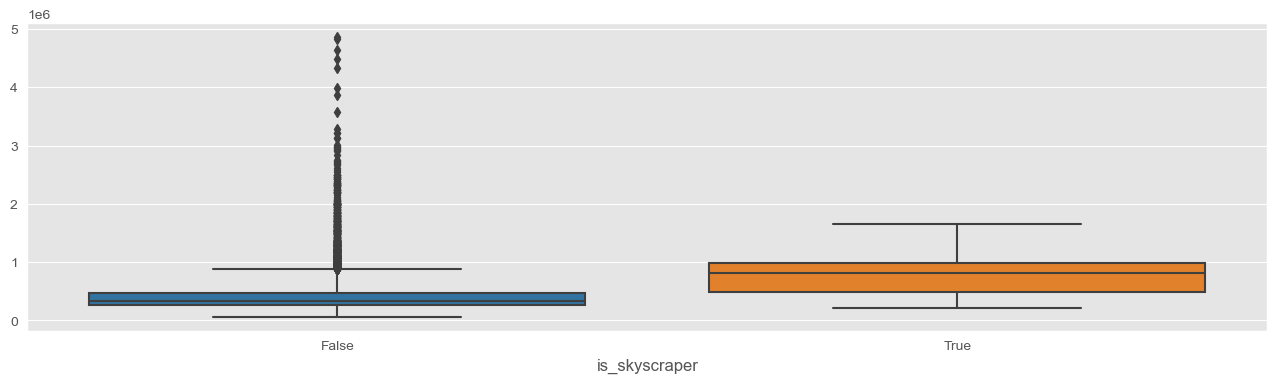

In [2002]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.boxplot(x = df.loc[df['is_skyscraper'].notnull(), 'is_skyscraper'], y = df.price/df.total_meters, whis = 2, \
                hue_order = np.sort(df.loc[df['is_skyscraper'].notnull(), i].unique()));
plt.show()

In [2003]:
to_ohe.add('is_skycraper')
to_ohe.add('floor_type')

to_drop.add('floor')
to_drop.add('floors_count')

### flat_type, house_type ###

In [2004]:
df.flat_type.value_counts()

Вторичка                   8545
Новостройка                7460
Вторичка Апартаменты       1507
Новостройка Апартаменты    1325
Вторичка Пентхаус           242
Новостройка Пентхаус         65
Name: flat_type, dtype: int64

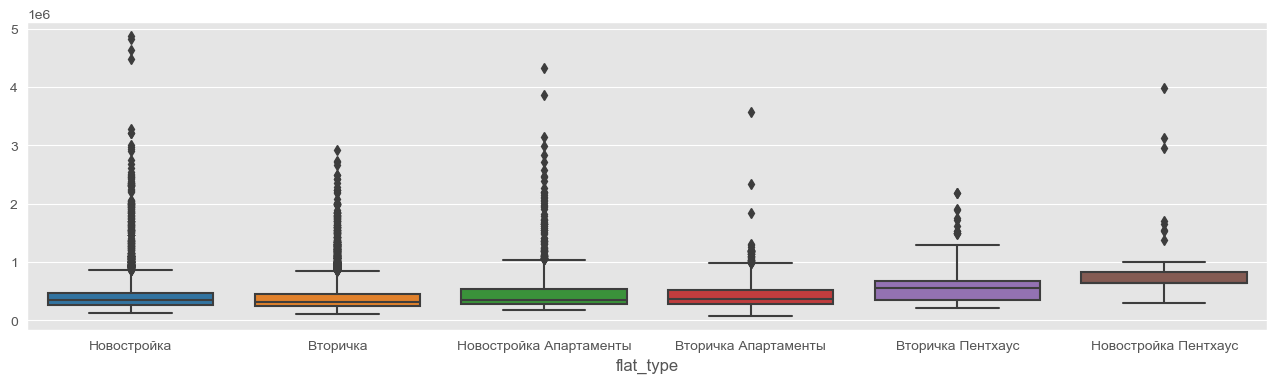

In [2005]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.boxplot(x = df.loc[df['flat_type'].notnull(), 'flat_type'], y = df.price/df.total_meters, whis = 2, \
                hue_order = np.sort(df.loc[df['flat_type'].notnull(), i].unique()));
plt.show()

In [2006]:
df.house_type.value_counts()

Монолитный                                    9605
Кирпичный                                     2194
Панельный                                     1921
Монолитно-кирпичный                           1616
Монолитно-кирпичный, монолитный                939
Панельный, монолитный                          402
Блочный                                        326
Монолитно-кирпичный, монолитный, кирпичный      10
Газосиликатный блок                              7
Сталинский                                       6
Панельный, кирпичный                             5
Старый фонд                                      1
Name: house_type, dtype: int64

In [2007]:
house_types = {
    'Монолитный':'Монолитный',
    'Монолитно-кирпичный':'Монолитный',
    'Монолитно-кирпичный, монолитный':'Монолитный',
    'Монолитно-кирпичный, монолитный, кирпичный':'Монолитный',
    'Панельный, монолитный':'Панельный',
    'Панельный, кирпичный':'Панельный',
}

In [2008]:
df.house_type = df.house_type.replace(house_types)

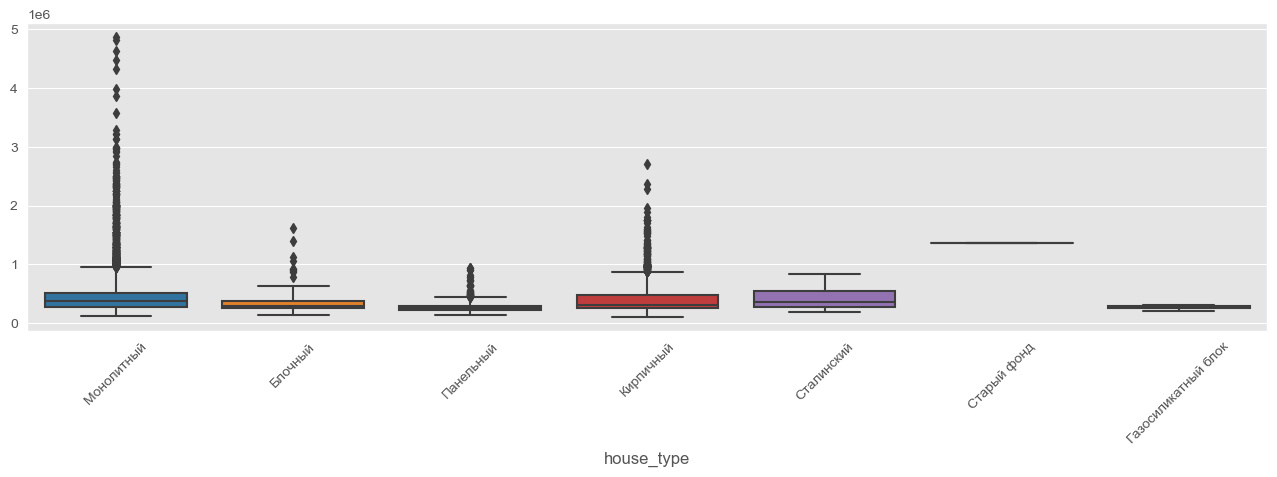

In [2009]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.boxplot(x = df.loc[df['house_type'].notnull(), 'house_type'], y = df.price/df.total_meters, whis = 2, \
                hue_order = np.sort(df.loc[df['house_type'].notnull(), i].unique()));
ax.tick_params(axis='x', rotation=45)
plt.show()

In [2010]:
to_ohe.add('flat_type')
to_ohe.add('house_type')

### wc ###

In [2011]:
df.wc.value_counts()

1 совмещенный                  5834
1 раздельный                   2611
2 совмещенных                  2451
3 совмещенных                   979
1 совмещенный, 1 раздельный     857
2 раздельных                    643
2 совмещенных, 1 раздельный     536
3 совмещенных, 1 раздельный     313
4 совмещенных                   246
3 раздельных                    213
2 совмещенных, 2 раздельных     114
4 раздельных                     88
1 совмещенный, 2 раздельных      53
4 совмещенных, 1 раздельный      49
3 совмещенных, 2 раздельных      16
1 совмещенный, 3 раздельных      14
4 совмещенных, 4 раздельных      14
3 совмещенных, 3 раздельных       9
2 совмещенных, 4 раздельных       4
1 совмещенный, 4 раздельных       3
2 совмещенных, 3 раздельных       3
4 совмещенных, 2 раздельных       2
4 совмещенных, 3 раздельных       1
Name: wc, dtype: int64

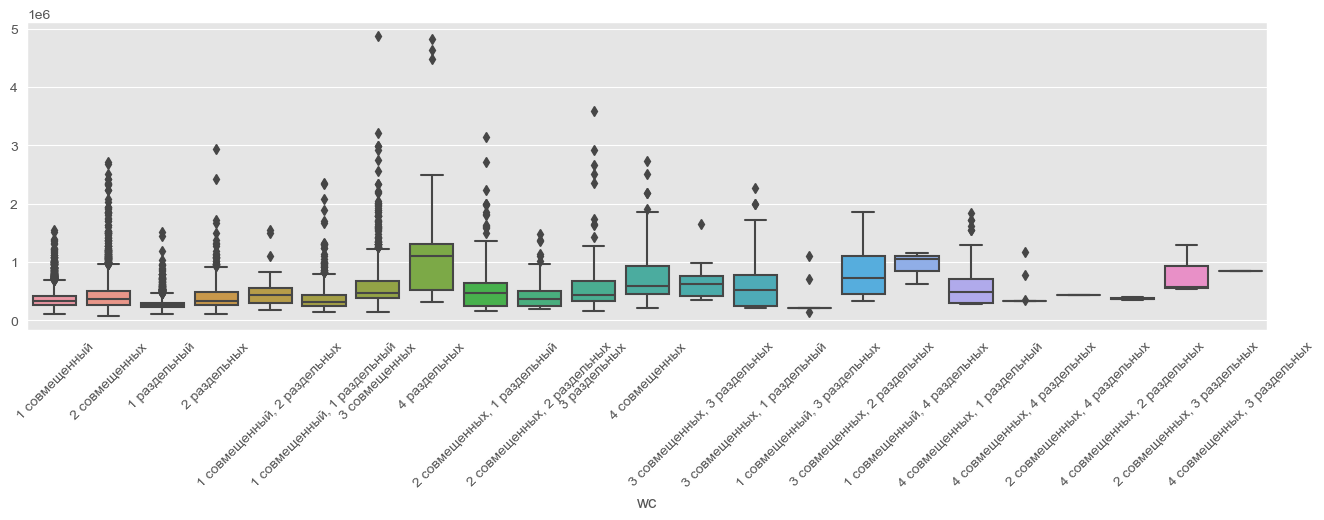

In [2012]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.boxplot(x = df.loc[df['wc'].notnull(), 'wc'], y = df.price/df.total_meters, whis = 2, \
                hue_order = np.sort(df.loc[df['wc'].notnull(), i].unique()));
ax.tick_params(axis='x', rotation=45)
plt.show()

In [2013]:
df[df.wc.isna()]['total_meters'].describe()

count    4091.000000
mean       88.237839
std        60.422278
min         9.000000
25%        43.000000
50%        69.000000
75%       119.000000
max       687.000000
Name: total_meters, dtype: float64

In [2014]:
wc_count = {
    None: 1,
    '1 совмещенный':1,
    '1 раздельный':1,
    '2 совмещенных':2,                  
    '1 совмещенный, 1 раздельный':2,    
    '2 раздельных':2,                   
    '3 совмещенных':3,                  
    '2 совмещенных, 1 раздельный':2,    
    '3 раздельных':3,                   
    '1 совмещенный, 2 раздельных':3,    
    '2 совмещенных, 2 раздельных':4,    
    '4 раздельных':4,                   
    '4 совмещенных':4,                  
    '3 совмещенных, 3 раздельных':6,    
    '3 совмещенных, 1 раздельный':4,    
    '1 совмещенный, 4 раздельных':5,
    
    '4 совмещенных, 1 раздельный':5,
    '4 совмещенных, 4 раздельных':8,
    '3 совмещенных, 2 раздельных':5,
    '1 совмещенный, 3 раздельных':4,
    '2 совмещенных, 4 раздельных':6,
    '4 совмещенных, 2 раздельных':6,
    '2 совмещенных, 3 раздельных':5,
    '4 совмещенных, 3 раздельных':7
}


wc_type = {
    None:'совмещенный',
    '1 совмещенный':'совмещенный',
    '1 раздельный':'раздельный',
    '2 совмещенных':'совмещенный',                  
    '1 совмещенный, 1 раздельный':'совмещенный',    
    '2 раздельных':'раздельный',                   
    '3 совмещенных':'совмещенный',                  
    '2 совмещенных, 1 раздельный':'совмещенный',    
    '3 раздельных':'раздельный',                   
    '1 совмещенный, 2 раздельных':'раздельный',    
    '2 совмещенных, 2 раздельных':'совмещенный',    
    '4 раздельных':'раздельный',                   
    '4 совмещенных':'совмещенный',                  
    '3 совмещенных, 3 раздельных':'совмещенный',    
    '3 совмещенных, 1 раздельный':'совмещенный',    
    '1 совмещенный, 4 раздельных':'раздельный',
    '4 совмещенных, 1 раздельный':'совмещенный',
    '4 совмещенных, 4 раздельных':'совмещенный',
    '3 совмещенных, 2 раздельных':'совмещенный',
    '1 совмещенный, 3 раздельных':'раздельный',
    '2 совмещенных, 4 раздельных':'раздельный',
    '4 совмещенных, 2 раздельных':'совмещенный',
    '2 совмещенных, 3 раздельных':'раздельный',
    '4 совмещенных, 3 раздельных':'совмещенный'
}


In [2015]:
df['wc_count'] = df.wc.replace(wc_count)
df['wc_type'] = df.wc.replace(wc_type)

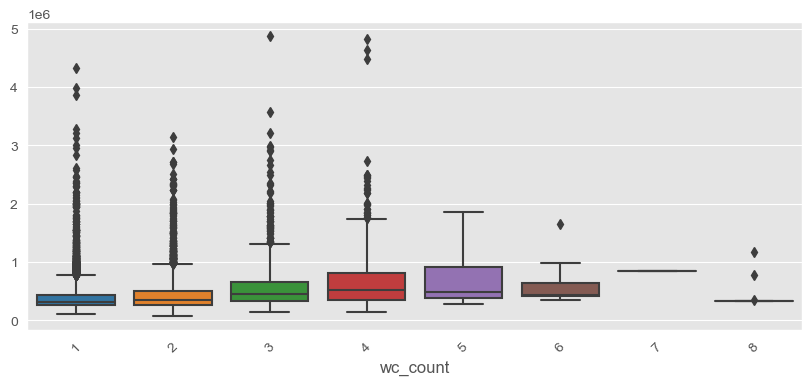

In [2016]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x = df.loc[df['wc_count'].notnull(), 'wc_count'], y = df.price/df.total_meters, whis = 2);
ax.tick_params(axis='x', rotation=45)
plt.show()

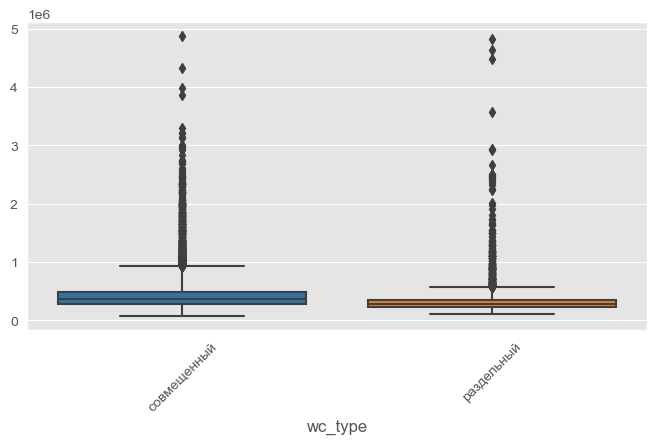

In [2017]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(x = df.loc[df['wc_type'].notnull(), 'wc_type'], y = df.price/df.total_meters, whis = 2);
ax.tick_params(axis='x', rotation=45)
plt.show()

In [2018]:
to_ohe.add('wc_type')
to_scale.add('wc_count')

### class - класс жилья ###

In [2019]:
df['class'].value_counts()

Бизнес     2847
Комфорт    2580
Премиум    1198
Name: class, dtype: int64

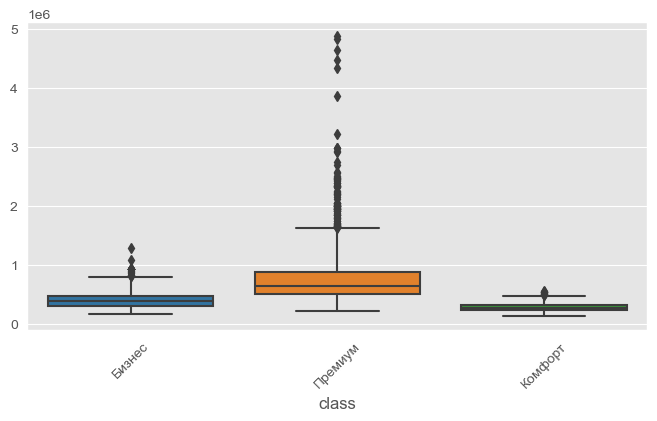

In [2020]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(x = df.loc[df['class'].notnull(), 'class'], y = df.price/df.total_meters, whis = 2, \
                hue_order = np.sort(df.loc[df['class'].notnull(), i].unique()));
ax.tick_params(axis='x', rotation=45)
plt.show()

Есть очевидная разница между Премиумом и Бизнес/Комфортом

In [2021]:
def get_class (row):
    if row['price']/row['total_meters'] < 240000 :
        return 'эконом'
    elif  row['price']/row['total_meters'] < 290000 :
        return 'комфорт'
    elif row['price']/row['total_meters'] < 400000 :
        return 'бизнес'
    elif row['price']/row['total_meters'] < 700000 :
        return 'премиум'
    return 'элитный'

In [2022]:
df['class_real'] = df.apply (lambda row: get_class(row), axis=1)

In [2023]:
df['class_real'].value_counts()

премиум    5413
бизнес     5090
комфорт    3544
эконом     3391
элитный    1706
Name: class_real, dtype: int64

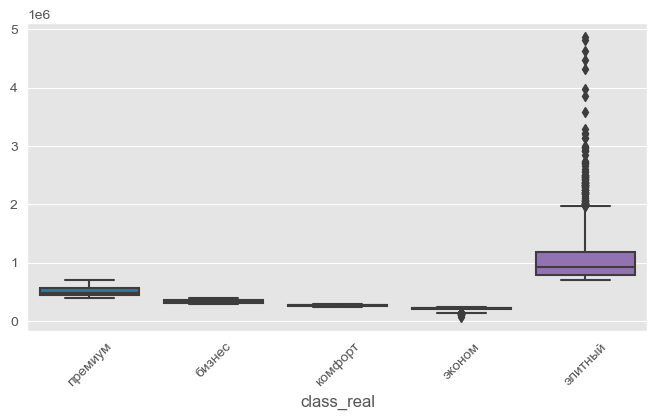

In [2024]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(x = df.loc[df['class_real'].notnull(), 'class_real'], y = df.price/df.total_meters, whis = 2, \
                hue_order = np.sort(df.loc[df['class_real'].notnull(), i].unique()));
ax.tick_params(axis='x', rotation=45)
plt.show()

In [2025]:
to_ohe.add('class_real')
to_drop.add('class')

### Убираем последние лишние столбцы

In [2026]:
to_drop.add('ceiling')
to_drop.add('wc')

In [2027]:
to_drop.add('by_foot')
to_ohe.add('is_skyscraper')
to_ohe.add('is_euro')
to_encode.add('rooms')

In [2028]:
print("Убираем: ", to_drop)
print("Закодировать: ", to_encode)
print("OHE: ", to_ohe)
print("Standard Scaler: ", to_scale)
print("Log: ", to_log)

Убираем:  {'floors_count', 'city', 'wc', 'class', 'living_meters', 'ceiling', 'by_foot', 'floor'}
Закодировать:  {'rooms', 'year_of_construction'}
OHE:  {'way_to_subway', 'subway', 'floor_type', 'wc_type', 'admin_okrug', 'is_skyscraper', 'house_type', 'flat_type', 'is_euro', 'district', 'class_real', 'is_skycraper'}
Standard Scaler:  {'dist_to_subway, min', 'wc_count'}
Log:  {'kitchen_meters', 'price', 'total_meters'}


In [2029]:
lost = set()
union = {*to_drop, *to_encode, *to_scale, *to_log, *to_ohe}
for i in df.columns:
    if i not in union:
        lost.add(i)

In [2030]:
lost

{'home_number', 'street'}

In [2031]:
df.drop(to_drop, axis=1, inplace=True)

In [2032]:
df.head()

rooms     subway admin_okrug                  district  \
0      1    Спартак        СЗАО  р-н Покровское-Стрешнево   
1      1   Шелепиха        СЗАО     р-н Хорошево-Мневники   
2      1  Стрешнево        СЗАО                р-н Щукино   
3      1   Шелепиха        СЗАО     р-н Хорошево-Мневники   
4      1    Спартак        СЗАО  р-н Покровское-Стрешнево   

                     street                         home_number       price  \
0                   Алиа ЖК                                  к7  16781328.0   
1  Шелепихинская набережная                                34к7  16500000.0   
2           Щукинская улица                               7/9С7  20540352.0   
3  Шелепихинская набережная                                34к3  20800000.0   
4        Северо-Западный ао  Клубный Город на Реке Примавера ЖК  30460120.0   

  year_of_construction  total_meters  kitchen_meters    flat_type  house_type  \
0                 2023          37.0            11.0  Новостройка  Монолитный   
1                 2024          42.0            12.0  Новостройка  Монолитный   
2                 2023          47.0            16.0  Новостройка  Монолитный   
3                 2020          32.0            11.0     Вторичка  Монолитный   
4                 2024          52.0            11.0  Новостройка  Монолитный   

   dist_to_subway, min way_to_subway  is_euro  is_skyscraper floor_type  \
0                  5.0        пешком    False          False      usual   
1                 14.0        пешком    False          False      usual   
2                 10.0        пешком    False          False      usual   
3                 14.0        пешком    False          False       view   
4                 14.0        пешком    False          False      usual   

   wc_count      wc_type class_real  
0         1  совмещенный    премиум  
1         1  совмещенный     бизнес  
2         2  совмещенный    премиум  
3         1  совмещенный    премиум  
4         1   раздельный    премиум

In [2033]:
df.columns

Index(['rooms', 'subway', 'admin_okrug', 'district', 'street', 'home_number',
       'price', 'year_of_construction', 'total_meters', 'kitchen_meters',
       'flat_type', 'house_type', 'dist_to_subway, min', 'way_to_subway',
       'is_euro', 'is_skyscraper', 'floor_type', 'wc_count', 'wc_type',
       'class_real'],
      dtype='object')

### Сохраняем в файле с трансформированными данными

In [2034]:
df.to_csv('../data/processed/all_rooms_combined.csv',index=True)

### На случай обработки пакетной запускаем функцию

In [1649]:
# def get_dist_to_subway_by(x):
#     if 'пешком' in x:
#         return 'пешком'
#     elif 'на транспорте' in x:
#         return 'на транспорте'
#     else:
#         return '';

# def get_flat_type(x):
#     apart_flags = ['апарт', 'апартаменты', 'апартам']
#     if any( (flag in x['title']) | (flag in x['subtitle']) for flag in apart_flags):
#         return 'апартаменты'
#     else:
#         return 'квартира'

# def get_floor(x):
#     if x != '':
#         try:
#             return int(x.split()[0])
#         except:
#             return 0
#     else:
#         return 0

# def get_max_floor(x):
#     if x != '':
#         try:
#             return int(x.split()[2])
#         except:
#             return 0
#     else:
#         return 0
    
# def transform_data(i):
#     try:
#         df = pd.read_csv(f'{i}_rooms_full.csv')
#         df = df.drop(['Unnamed: 0', 'processed'], axis=1)
#         df['dist_to_subway'].fillna('', inplace=True)
#         df['dist_to_subway, min'] = df.dist_to_subway.str.extract('(\d+)')
#         df['dist_to_subway, means'] = df['dist_to_subway'].apply(get_dist_to_subway_by)
#         df.drop('dist_to_subway', axis=1, inplace=True)
#         df.price = df.price.apply(lambda x: x.replace(' ', '')).str.extract('(\d+)').apply(int, axis=1)
#         df.dropna(subset=['Общая'], inplace=True)
#         df['Жилая'].fillna('', inplace=True)
#         df['Кухня'].fillna('', inplace=True)
#         df['total_sq'] = df['Общая'].apply(lambda x: x.replace(',', '.')).str.extract('(\d+)').apply(int, axis=1)
#         df['living_sq'] = df['Жилая'].apply(lambda x: x.replace(',', '.')).str.extract('(\d+)').fillna(0).apply(int, axis=1)
#         df['kitchen_sq'] = df['Кухня'].apply(lambda x: x.replace(',', '.')).str.extract('(\d+)').fillna(0).apply(int, axis=1)
#         df.drop('Общая', axis=1, inplace=True)
#         df['floor'] = df['Этаж'].apply(lambda x: get_floor(x)).apply(int)
#         df['max_floor'] = df['Этаж'].apply(lambda x: get_max_floor(x)).apply(int)
#         df.drop('Этаж', axis=1, inplace=True)
#         df.rename(columns={'Построен':'built_year'}, inplace=True)
#         df.built_year.fillna(0, inplace=True)
#         df.built_year = df.built_year.apply(int)
#         df['kids_allowed'] = df.kids.apply(lambda x: 1 if x =='Можно с детьми' else 0)
#         df['pets_allowed'] = df.pets.apply(lambda x: 1 if x =='Можно с животными' else 0)
#         df.drop(['kids','pets'], axis = 1, inplace=True)
#         utils = ['fridge', 'washing', 'furniture', 'kitchen',
#            'dishwasher', 'cond', 'internet', 'shower', 'bath', 'tv']
#         for util in utils:
#             df[util].fillna('', inplace=True)
#             df[util] = df[util].apply(lambda x: 0 if x=='' else 1)
#         df['subtitle'].fillna('', inplace=True)
#         df['type_of_flat'] = df.apply(lambda x: get_flat_type(x), axis=1)
#         df.drop(['title', 'subtitle', 'link', 'Жилая', 'Кухня'], axis=1, inplace=True)
#         df.to_csv(f'{i}_rooms_transformed.csv', index=False)
#     except:
#         print(i)

In [1651]:
#for i in [1, 2, 3, 4, 5, 6, 9]:
#   transform_data(i)